In [ ]:
from __future__ import annotations

from pathlib import Path
from datetime import date, timedelta
from collections import Counter, defaultdict
import glob
import gc

import polars as pl
import matplotlib.pyplot as plt
import sqlite3
import math
import heapq
import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import polars as pl
from tqdm.auto import tqdm


## What “clusters” (entities) mean

A **cluster / entity** is a **connected component** in a graph:

- **Nodes = addresses**
- **Edges = “same controller” links** inferred from transaction patterns

A **cluster size** is simply: **how many addresses became connected** through these inferred links.

---

## Algorithm overview (step-by-step)

### 0) Define two time windows

Two overlapping windows are used:

- **Index window** `[INDEX_START, ANALYSIS_END)`  
  Build an outpoint index so inputs can be resolved to addresses.
- **Analysis window** `[ANALYSIS_START, ANALYSIS_END)`  
  Apply heuristics and add unions (one year of clustering).

Why this is necessary: **Bitcoin inputs do not contain an address**.  
An input only references a previous output (`prev_txid`, `prev_vout`). The address lives in that previous output.

---

### 1) Build an outpoint index (outputs → address)

For each day/file in the **index window**, take rows with `dir == "out"` and store:

- key: `(txid, n)` where `n` is output index (vout)
- value: `address`

This creates a local map: **(prev_txid, prev_vout) → address**, which allows later recovery of input addresses.

---

### 2) Resolve input addresses (prevouts → address)

For each day/file in the **analysis window**, for every row with `dir == "in"`:

- `spend_txid` = spending transaction id
- `(prev_txid, prev_vout)` = the referenced output being spent

Then:

- count total inputs per spending tx: `input_utxo_count[spend_txid] += 1`
- look up `(prev_txid, prev_vout)` in the outpoint index to obtain the **input address**
- group resolved input addresses per spending tx:  
  `inputs_by_txid[spend_txid] = {addr1, addr2, ...}`

Important:
- `input_utxo_count` counts **all inputs** (even unresolved)
- `inputs_by_txid` contains only **resolved input addresses**

---

### 3) Group outputs per transaction

Still within the analysis window, group `dir == "out"` rows by `txid` and collect:

- `out_addrs: [address, ...]`
- `out_values: [value, ...]`

Now each transaction can be analyzed using:
- input UTXO count,
- resolved input addresses,
- output addresses + output amounts.

---

### 4) Per transaction: apply filters + heuristics → add “same owner” edges

For each transaction `txid` that has outputs and at least one input:

#### 4.1 Skip transactions with insufficient structure
- no outputs → skip
- `input_utxo_count[txid] == 0` → skip

#### 4.2 Skip collaborative patterns (CoinJoin-like)
A simple CoinJoin-ish filter flags a transaction if:
- `n_in_utxos >= 3`
- `n_out >= 3`
- at least 3 outputs share exactly the same amount

If flagged:
- **do not add any unions**
- only mark outputs as “seen” (for later “new output” checks)

Goal: avoid linking unrelated participants.

#### 4.3 Multi-input heuristic (high-signal link)
If `n_in_utxos >= 2`:
- take the **resolved unique input addresses** for this tx
- if there are ≥2 distinct resolved input addresses → connect (union) them all
- if only 1 resolved input address → mark it as participating, but no additional links can be created

Interpretation: spending multiple inputs in one transaction usually requires control over all corresponding private keys (or custody over them), so they are treated as belonging to the same entity.

#### 4.4 Change heuristic (riskier link)
Attempt to identify exactly one output that is likely “change” back to the spender:

Candidate output must satisfy all:
- output address is **not** one of the resolved input addresses (not a self-send)
- output address type matches the **majority input type** (prefix-based: `1...`, `3...`, `bc1...`)
- output address is **new as an output** (has not appeared before as an output)

If *exactly one* candidate remains:
- label it as change
- connect (union) it to an input address (e.g., the first resolved input)

Finally:
- mark all outputs as “seen” to support future “new output” tests.

---

### 5) After scanning all files: compress unions → entity IDs → cluster sizes

After processing the entire analysis window:

1) compute each address’s Union-Find root
2) assign a contiguous `entity_id` per root
3) compute cluster sizes (e.g., via `bincount(entity_id)`)
4) report:
   - largest cluster size and fraction
   - top-K cluster sizes
   - quantiles (median/90th/99th)
   - heuristic coverage (how many nodes were linked by which heuristic)
5) optionally write mapping `(address → entity_id)` to Parquet (ideally in chunks)

---

## How to interpret “less permissive union” results

The typical outcome is **heavy-tailed**:

- many clusters of size 1–10
- fewer clusters of size 10–1000
- very few clusters of size 10k+

Sometimes there is a **giant component** (largest cluster far larger than the rest).  
This can be:
- **plausible**: large custodial/service wallets consolidating many deposits
- **a red flag**: false change links “bridge” unrelated clusters, causing cascade merges

Tightening change inference typically causes:
- fewer unions,
- more fragmentation (more clusters),
- reduced dominance of the largest cluster (if change links were the main bridge source).

If the largest cluster stays huge even with strict change rules, it is often driven by multi-input consolidation patterns of large services, or by collaborative transactions not caught by the filter.

In [ ]:
# -----------------------------
# Sanity checks + prevout join sanity
# -----------------------------
from collections import Counter
import math

OUTPUT_DIR_VALUES = {"out", "vout", "output", "o"}
INPUT_DIR_VALUES  = {"in", "vin", "input", "i"}

def run_sanity_checks(
    n_nodes: int,
    node_to_entity: list[int] | np.ndarray | None = None,
    cluster_size_counter: Counter | None = None,
    prevout_lookups: int | None = None,
    prevout_hits: int | None = None,
    top_k: int = 20,
) -> None:
    """
    Prints:
      - largest cluster fraction of nodes
      - top cluster sizes
      - entity count stats
      - optional prevout hit-rate
    Provide either node_to_entity OR cluster_size_counter.
    """
    if cluster_size_counter is None:
        if node_to_entity is None:
            raise ValueError("Provide either node_to_entity or cluster_size_counter.")
        cluster_size_counter = Counter(list(node_to_entity))

    sizes = list(cluster_size_counter.values())
    if not sizes:
        print("[SANITY] No clusters found (sizes empty).")
        return

    sizes_sorted = sorted(sizes, reverse=True)
    total_nodes_from_sizes = sum(sizes_sorted)
    largest = sizes_sorted[0]
    frac = largest / total_nodes_from_sizes if total_nodes_from_sizes else float("nan")

    print("\n[SANITY] Cluster summary")
    print(f"  UF nodes (n_nodes): {n_nodes:,}")
    print(f"  Total nodes from cluster sizes: {total_nodes_from_sizes:,}")
    if total_nodes_from_sizes != n_nodes:
        print("  [WARN] sum(cluster_sizes) != n_nodes  -> mismatch suggests a bug in mapping logic.")
    print(f"  Entities (clusters): {len(cluster_size_counter):,}")
    print(f"  Largest cluster size: {largest:,}")
    print(f"  Largest cluster fraction of nodes: {frac:.2%}")

    print(f"\n[SANITY] Top {top_k} cluster sizes:")
    print(" ", sizes_sorted[:top_k])

    # nearest-rank percentile helper
    def pct(p: float) -> int:
        if not sizes_sorted:
            return 0
        s_asc = sorted(sizes_sorted)
        idx = max(0, min(len(s_asc) - 1, math.ceil(p * len(s_asc)) - 1))
        return int(s_asc[idx])

    med = int(sorted(sizes_sorted)[len(sizes_sorted) // 2])
    print("\n[SANITY] Quick distribution stats")
    print(f"  Median cluster size: {med:,}")
    print(f"  90th percentile cluster size: {pct(0.90):,}")
    print(f"  99th percentile cluster size: {pct(0.99):,}")

    if prevout_lookups is not None and prevout_hits is not None:
        rate = (prevout_hits / prevout_lookups) if prevout_lookups else float("nan")
        print("\n[SANITY] Prevout lookup hit-rate (DB)")
        print(f"  Lookups:  {prevout_lookups:,}")
        print(f"  Hits:     {prevout_hits:,}")
        print(f"  Hit-rate: {rate:.2%}")


def prevout_join_sanity_polars(one_io_parquet: str) -> None:
    """
    Pure-Polars sanity on a single parquet:
      - prev_vout integer-likeness
      - duplicate outpoints (txid,n)
      - left join vin->vout inside same parquet
      - match explosion check
    Note: This join only resolves prevouts that point to outputs present in this same file.
    Your real pipeline resolves against the outpoint DB across days.
    """
    df = pl.read_parquet(one_io_parquet, columns=["dir","txid","n","prev_txid","prev_vout","address","value"])

    df = df.with_columns(pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().alias("dir"))

    vout = (
        df.filter(pl.col("dir").is_in(list(OUTPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("out_txid"),
              pl.col("n").cast(pl.Int64, strict=False).alias("out_n"),
              pl.col("address").alias("out_address"),
              pl.col("value").alias("out_value"),
          ])
          .filter(pl.col("out_txid").is_not_null() & pl.col("out_n").is_not_null())
    )

    vin = (
        df.filter(pl.col("dir").is_in(list(INPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid").alias("prev_txid"),
              pl.col("prev_vout").alias("prev_vout"),
          ])
          .filter(pl.col("spend_txid").is_not_null() & pl.col("prev_txid").is_not_null())
    )

    print("\n[PREVOUT-SANITY | POLARS]")
    print("File:", one_io_parquet)
    print("Rows:", {"vin": vin.height, "vout": vout.height})

    # 1) Check prev_vout is integer-like (if float-ish in schema)
    vin_nonnull = vin.filter(pl.col("prev_vout").is_not_null())
    if vin_nonnull.height > 0:
        frac_integerlike = (
            vin_nonnull
            .with_columns(((pl.col("prev_vout") - pl.col("prev_vout").floor()).abs() < 1e-9).alias("is_intlike"))
            .select(pl.col("is_intlike").mean())
            .item()
        )
        print(f"prev_vout integer-like fraction: {float(frac_integerlike):.6f}")

    # Cast prev_vout safely to int for joining
    vin2 = vin.with_columns(
        pl.when(pl.col("prev_vout").is_not_null())
          .then(pl.col("prev_vout").cast(pl.Int64, strict=False))
          .otherwise(None)
          .alias("prev_vout_i64")
    )

    # 2) Check uniqueness of outpoints
    dupe_outpoints = (
        vout.group_by(["out_txid","out_n"])
            .len()
            .filter(pl.col("len") > 1)
            .height
    )
    print("Duplicate outpoints (should be 0):", dupe_outpoints)

    # 3) Join vin prevouts -> vout outpoints (within same file)
    joined = (
        vin2.join(
            vout,
            left_on=["prev_txid","prev_vout_i64"],
            right_on=["out_txid","out_n"],
            how="left",
        )
    )

    resolved = joined.filter(pl.col("out_address").is_not_null()).height
    lookups  = vin.height
    print(f"Prevout resolution hit-rate (within-file): {resolved}/{lookups} = {resolved/lookups:.2%}" if lookups else "No vin rows")

    # 4) Check for join explosion: each input should match <= 1 output
    if joined.height > 0:
        max_matches_per_input = (
            joined.group_by(["spend_txid","prev_txid","prev_vout_i64"])
                  .len()
                  .select(pl.col("len").max())
                  .item()
        )
        print("Max matches per (spend_txid, prev_txid, prev_vout):", int(max_matches_per_input) if max_matches_per_input is not None else None)

    sample_unresolved = (
        joined.filter(pl.col("out_address").is_null())
              .select(["spend_txid","prev_txid","prev_vout_i64"])
              .head(5)
    )
    print("\nSample unresolved inputs (within-file):")
    print(sample_unresolved)


def prevout_join_sanity_db(conn: sqlite3.Connection, one_io_parquet: str, sample_limit: int = 200_000) -> None:
    """
    Sanity-check using your ACTUAL outpoint DB resolution:
      - reads vin from a single parquet
      - casts prev_vout -> int64
      - looks up in DB using your lookup_outpoints_hybrid
      - prints DB hit-rate and sample unresolved keys
    Uses only a sample of inputs (sample_limit) to keep it cheap.
    """
    df = pl.read_parquet(one_io_parquet, columns=["dir","txid","prev_txid","prev_vout"])
    df = df.with_columns(pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().alias("dir"))

    vin = (
        df.filter(pl.col("dir").is_in(list(INPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid").alias("prev_txid"),
              pl.col("prev_vout").alias("prev_vout"),
          ])
          .filter(pl.col("prev_txid").is_not_null() & pl.col("prev_vout").is_not_null())
          .head(sample_limit)
    )

    print("\n[PREVOUT-SANITY | DB]")
    print("File:", one_io_parquet)
    print("Vin sample rows:", vin.height)

    if vin.height == 0:
        print("No vin rows in sample.")
        return

    # integer-likeness check
    frac_integerlike = (
        vin.with_columns(((pl.col("prev_vout") - pl.col("prev_vout").floor()).abs() < 1e-9).alias("is_intlike"))
           .select(pl.col("is_intlike").mean())
           .item()
    )
    print(f"prev_vout integer-like fraction (sample): {float(frac_integerlike):.6f}")

    vin2 = vin.with_columns(
        pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_vout_i64")
    ).filter(pl.col("prev_vout_i64").is_not_null())

    keys = [
        (prev_txid, int(prev_n))
        for prev_txid, prev_n in vin2.select(["prev_txid", "prev_vout_i64"]).iter_rows(named=False, buffer_size=200_000)
    ]
    if not keys:
        print("No usable keys after casting prev_vout.")
        return

    hits = lookup_outpoints_hybrid(conn, keys)
    resolved = len(hits)
    lookups = len(keys)

    print(f"DB prevout hit-rate (sample): {resolved}/{lookups} = {resolved/lookups:.2%}")

    # show unresolved examples
    unresolved = []
    for k in keys[:5000]:
        if k not in hits:
            unresolved.append(k)
            if len(unresolved) >= 10:
                break
    if unresolved:
        print("Sample unresolved (prev_txid, prev_n):")
        for k in unresolved:
            print(" ", k)
    else:
        print("No unresolved keys in first 5000 keys (good sign).")


### PathsConfig

- `parquet_io_glob = "/media/vatereal/Main/parquet/io/day=*/io-*.parquet"`
  1) **Name + value set:** `parquet_io_glob = "/media/vatereal/Main/parquet/io/day=*/io-*.parquet"`
  2) **Reflects:** Input discovery pattern (which parquet files exist in-scope).
  3) **Update higher/lower:** Not numeric; change when dataset layout/naming changes (different root, partitions, filenames).

- `outputs_dir = "/media/vatereal/Main/outputs"`
  1) **Name + value set:** `outputs_dir = "/media/vatereal/Main/outputs"`
  2) **Reflects:** Where all artifacts are written (SQLite DB, parquet mapping, logs).
  3) **Update higher/lower:** Not numeric; move to faster storage (NVMe/SSD) for major speedups in SQLite + Parquet writes.

- `outpoint_db_path = "/media/vatereal/Main/outputs/outpoints_2014.sqlite"`
  1) **Name + value set:** `outpoint_db_path = outputs_dir / "outpoints_2014.sqlite"`
  2) **Reflects:** SQLite cache of outpoints used for prevout resolution (drives hit-rate and speed).
  3) **Update higher/lower:** Not numeric; keep year/window-specific; place on fast disk; avoid reusing across different settings.

- `entity_map_out_path = "/media/vatereal/Main/outputs/entities_multiinput_change_2014.parquet"`
  1) **Name + value set:** `entity_map_out_path = outputs_dir / "entities_multiinput_change_2014.parquet"`
  2) **Reflects:** Final artifact: `address -> entity_id` mapping output.
  3) **Update higher/lower:** Not numeric; version outputs when heuristics/guards change to preserve comparability.

---

### AnalysisConfig

- `analysis_start = date(2014, 1, 1)`
  1) **Name + value set:** `analysis_start = 2014-01-01`
  2) **Reflects:** Inclusive start of clustering window.
  3) **Update higher/lower:** Not numeric; move earlier/later to target a different time period.

- `analysis_end_exclusive = date(2015, 1, 1)`
  1) **Name + value set:** `analysis_end_exclusive = 2015-01-01 (exclusive)`
  2) **Reflects:** Exclusive end of clustering window.
  3) **Update higher/lower:** Not numeric; set to `year+1` for 1-year runs; extend for multi-year runs.

- `outpoint_db_lookback_days = 365`
  1) **Name + value set:** `outpoint_db_lookback_days = 365`
  2) **Reflects:** How far back to preload outputs so analysis inputs can resolve prevouts.
  3) **Update higher/lower:**
     - **Higher:** improves prevout hit-rate / change eligibility when UTXOs are old.
     - **Lower:** faster preload but more unresolved inputs (more skipped txs).

- `value_unit_mode = "infer"`
  1) **Name + value set:** `value_unit_mode = "infer"`
  2) **Reflects:** Whether `value` is interpreted as BTC vs sats (infer by magnitude).
  3) **Update higher/lower:**
     - Use `"btc"` / `"sats"` if schema is known (safer).
     - Keep `"infer"` only if dataset is consistent and you trust inference.

---

### OutputConfig

- `reset_outpoint_db = True`
  1) **Name + value set:** `reset_outpoint_db = True`
  2) **Reflects:** Whether DB is rebuilt from scratch (reproducibility).
  3) **Update higher/lower:**
     - **False:** only when reusing a DB built from the exact same input/window/lookback/settings.
     - **True:** when iterating heuristics or debugging.

- `write_entity_mapping = True`
  1) **Name + value set:** `write_entity_mapping = True`
  2) **Reflects:** Whether to write `address -> entity_id` parquet.
  3) **Update higher/lower:**
     - **False:** faster diagnostics runs.
     - **True:** final outputs.

- `entity_map_compression = "zstd"`
  1) **Name + value set:** `entity_map_compression = "zstd"`
  2) **Reflects:** Output size vs write speed tradeoff.
  3) **Update higher/lower:**
     - `"snappy"` for faster writes / larger file.
     - `"zstd"` for smaller files / usually fine speed.

- `entity_write_batch = 1_000_000`
  1) **Name + value set:** `entity_write_batch = 1,000,000`
  2) **Reflects:** Rows buffered per parquet write (speed vs memory).
  3) **Update higher/lower:**
     - **Higher:** fewer write calls (faster) if RAM allows.
     - **Lower:** reduces memory spikes.

- `top_k_clusters_print = 20`
  1) **Name + value set:** `top_k_clusters_print = 20`
  2) **Reflects:** Log verbosity for top clusters.
  3) **Update higher/lower:** Higher for debugging; lower for cleaner logs.

---

### PlotConfig

- `enable_plots = True`
  1) **Name + value set:** `enable_plots = True`
  2) **Reflects:** Whether to run matplotlib diagnostics (no clustering effect).
  3) **Update higher/lower:** False for headless/throughput runs; True when iterating heuristics.

- `zipf_top_k = 200_000`
  1) **Name + value set:** `zipf_top_k = 200,000`
  2) **Reflects:** How many top clusters appear in the rank-size plot.
  3) **Update higher/lower:** Higher for more tail detail; lower if plotting is slow.

- `focus_max_size = 2048`
  1) **Name + value set:** `focus_max_size = 2048`
  2) **Reflects:** Upper cutoff for the “zoomed” histogram region.
  3) **Update higher/lower:** Lower to zoom in on small wallets; higher to inspect mid-sized clusters.

- `log_bins = 40`
  1) **Name + value set:** `log_bins = 40`
  2) **Reflects:** Histogram resolution in log-space.
  3) **Update higher/lower:** Higher for finer detail (can get noisy); lower for smoother plots.

---

### PerfConfig

- `outpoint_commit_every_rows = 500_000`
  1) **Name + value set:** `outpoint_commit_every_rows = 500,000`
  2) **Reflects:** SQLite commit granularity (throughput vs stall/WAL behavior).
  3) **Update higher/lower:**
     - **Higher:** fewer commits (often faster) if stable.
     - **Lower:** smaller transactions if WAL growth/stalls appear.

- `prevout_hybrid_threshold = 5_000`
  1) **Name + value set:** `prevout_hybrid_threshold = 5,000`
  2) **Reflects:** Legacy lookup mode switch (mostly relevant to sanity helper).
  3) **Update higher/lower:** Usually leave as-is under Patch 3; only matters if legacy path is used.

- `prevout_lookup_chunk = 50_000`
  1) **Name + value set:** `prevout_lookup_chunk = 50,000`
  2) **Reflects:** Chunk size for legacy join buffer (sanity helper).
  3) **Update higher/lower:** Increase if using legacy path and RAM allows; decrease if SQLite temp memory pressure.

- `iter_buffer_in = 200_000`
  1) **Name + value set:** `iter_buffer_in = 200,000`
  2) **Reflects:** Polars→Python iteration chunk size for VIN extraction.
  3) **Update higher/lower:** Higher for speed if RAM allows; lower to reduce memory spikes.

- `iter_buffer_out = 200_000`
  1) **Name + value set:** `iter_buffer_out = 200,000`
  2) **Reflects:** Polars→Python iteration chunk size for VOUT/outpoint indexing.
  3) **Update higher/lower:** Same as `iter_buffer_in`.

- `iter_buffer_grouped = 50_000`
  1) **Name + value set:** `iter_buffer_grouped = 50,000`
  2) **Reflects:** Iteration chunk size for per-tx joined rows.
  3) **Update higher/lower:** Higher for speed if stable; lower if joined rows are heavy.

- `gc_every_n_files = 100`
  1) **Name + value set:** `gc_every_n_files = 100`
  2) **Reflects:** How often to trigger GC to control RSS.
  3) **Update higher/lower:** Lower if memory creeps upward; higher if GC pauses are noticeable.

- `tqdm_mininterval = 2.0`
  1) **Name + value set:** `tqdm_mininterval = 2.0`
  2) **Reflects:** Min seconds between tqdm refreshes.
  3) **Update higher/lower:** Higher reduces overhead; lower increases UI responsiveness.

- `tqdm_miniters = 50`
  1) **Name + value set:** `tqdm_miniters = 50`
  2) **Reflects:** Min iterations between tqdm refreshes.
  3) **Update higher/lower:** Higher reduces overhead; lower updates more frequently.

- `tqdm_postfix_every = 250`
  1) **Name + value set:** `tqdm_postfix_every = 250`
  2) **Reflects:** How often postfix status is updated.
  3) **Update higher/lower:** Higher reduces overhead; lower gives more live context.

- `use_sql_prevout_join = True`
  1) **Name + value set:** `use_sql_prevout_join = True`
  2) **Reflects:** Patch 3: set-based vinbuf→outpoints join in SQLite.
  3) **Update higher/lower:** Keep True for this build’s correctness/perf; False not supported in this patched version.

- `vinbuf_insert_chunk = 1_000_000`
  1) **Name + value set:** `vinbuf_insert_chunk = 1,000,000`
  2) **Reflects:** Batch size for inserting VIN rows into SQLite temp table.
  3) **Update higher/lower:** Higher for speed if RAM allows; lower if temp memory pressure/stalls.

- `vinbuf_fetch_chunk = 1_000_000`
  1) **Name + value set:** `vinbuf_fetch_chunk = 1,000,000`
  2) **Reflects:** Batch size for fetching aggregated join results from SQLite.
  3) **Update higher/lower:** Higher reduces fetch loops; lower reduces peak memory during transport.

---

### SanityConfig

- `run_sanity_checks = True`
  1) **Name + value set:** `run_sanity_checks = True`
  2) **Reflects:** Prints cluster summaries and prevout hit-rate diagnostics.
  3) **Update higher/lower:** Disable for max throughput once stable; enable during tuning.

- `run_prevout_db_sanity = True`
  1) **Name + value set:** `run_prevout_db_sanity = True`
  2) **Reflects:** Additional sampled prevout hit-rate test.
  3) **Update higher/lower:** Disable to save time once DB logic is trusted.

- `prevout_sanity_sample_limit = 200_000`
  1) **Name + value set:** `prevout_sanity_sample_limit = 200,000`
  2) **Reflects:** Sample size (confidence vs time).
  3) **Update higher/lower:** Higher for stronger confidence; lower for quick smoke checks.

- `prevout_sanity_parquet = None`
  1) **Name + value set:** `prevout_sanity_parquet = None`
  2) **Reflects:** Which parquet file is used for sanity sampling (None = auto-selected).
  3) **Update higher/lower:** Not numeric; set explicitly to compare runs consistently.

---

### HeuristicToggles

- `enable_coinjoin_filter = True`
  1) **Name + value set:** `enable_coinjoin_filter = True`
  2) **Reflects:** Whether mixing-like transactions are excluded from clustering.
  3) **Update higher/lower:** Disable for maximum linkage (more false merges); enable for conservative clustering.

- `enable_multi_input = True`
  1) **Name + value set:** `enable_multi_input = True`
  2) **Reflects:** Whether H1 multi-input unions are applied.
  3) **Update higher/lower:** Disable to study change-only behavior; enable for additional linkage.

- `enable_change = True`
  1) **Name + value set:** `enable_change = True`
  2) **Reflects:** Whether change heuristic unions are applied.
  3) **Update higher/lower:** Disable to study pure H1; enable for stronger wallet growth linkage.

- `enable_merge_guards = True`
  1) **Name + value set:** `enable_merge_guards = True`
  2) **Reflects:** Whether guardrails/caps/ratio/votes are enforced.
  3) **Update higher/lower:** Disable only for experiments; enable to avoid catastrophic bridging.

- `precreate_nodes_for_all_output_addrs = False`
  1) **Name + value set:** `precreate_nodes_for_all_output_addrs = False`
  2) **Reflects:** Whether every output address gets a UF node regardless of later resolution.
  3) **Update higher/lower:** True for maximal node universe; False to reduce UF size/RAM.

- `create_nodes_for_all_resolved_inputs = True`
  1) **Name + value set:** `create_nodes_for_all_resolved_inputs = True`
  2) **Reflects:** Preserve node universe for all resolved input addresses.
  3) **Update higher/lower:** Keep True for comparability/completeness; False only to reduce memory.

---

### HeuristicParams

- `dust_sats = 546`
  1) **Name + value set:** `dust_sats = 546`
  2) **Reflects:** Dust cutoff for “spendable” output logic.
  3) **Update higher/lower:** Higher if dust spam pollutes patterns; lower rarely.

- `max_fee_abs_sats = 50_000_000`
  1) **Name + value set:** `max_fee_abs_sats = 50,000,000`
  2) **Reflects:** Absolute fee sanity cap for change detection.
  3) **Update higher/lower:** Higher if high-fee regimes; lower for stricter filtering.

- `max_fee_frac = 0.05`
  1) **Name + value set:** `max_fee_frac = 0.05`
  2) **Reflects:** Fee cap as fraction of total input value.
  3) **Update higher/lower:** Higher if fee spikes expected; lower to be conservative.

- `max_change_inputs_utxos = 10`
  1) **Name + value set:** `max_change_inputs_utxos = 10`
  2) **Reflects:** Max input UTXOs to allow change heuristic.
  3) **Update higher/lower:** Higher includes consolidations (riskier); lower makes change stricter.

- `max_change_spendable_outs = 2`
  1) **Name + value set:** `max_change_spendable_outs = 2`
  2) **Reflects:** Max spendable outputs allowed for change heuristic.
  3) **Update higher/lower:** Higher increases coverage but risk; lower reduces false positives and coverage.

- `change_require_2_outputs = True`
  1) **Name + value set:** `change_require_2_outputs = True`
  2) **Reflects:** Require exactly 2 spendable outputs for change detection.
  3) **Update higher/lower:** False to allow 3-output logic; True for tightest behavior.

- `multi_input_policy = "one_output"`
  1) **Name + value set:** `multi_input_policy = "one_output"`
  2) **Reflects:** H1 fires only if there is exactly 1 spendable output (very conservative).
  3) **Update higher/lower:** `"one_or_two_nonmix"` increases coverage but raises false-positive risk.

- `enable_optimal_change_constraint = True`
  1) **Name + value set:** `enable_optimal_change_constraint = True`
  2) **Reflects:** Extra constraint intended to mimic coin selection optimality.
  3) **Update higher/lower:** Disable if too restrictive; enable for conservative change inference.

- `optimal_change_slack_sats = 0`
  1) **Name + value set:** `optimal_change_slack_sats = 0`
  2) **Reflects:** Tolerance around optimal-change inequality.
  3) **Update higher/lower:** Increase slightly if near-miss rejects due to rounding/fees; keep 0 for strictness.

---

### MergeGuardParams

- `max_merged_component_size = 1_500_000`
  1) **Name + value set:** `max_merged_component_size = 1,500,000`
  2) **Reflects:** Hard fail-safe cap on entity size (limits worst-case damage).
  3) **Update higher/lower:** Higher to allow very large services; lower to reduce catastrophic merge impact.

- `merge_ratio_guard = True`
  1) **Name + value set:** `merge_ratio_guard = True`
  2) **Reflects:** Enables lopsided-merge protection on CHANGE unions.
  3) **Update higher/lower:** Disable only if you accept bridging risk; otherwise keep enabled.

- `merge_ratio_max = 200.0`
  1) **Name + value set:** `merge_ratio_max = 200.0`
  2) **Reflects:** Maximum `s_big/s_small` allowed when ratio guard applies.
  3) **Update higher/lower:** Higher allows more growth (more risk); lower blocks more merges (more conservative).

- `merge_ratio_big_cluster_min = 50_000`
  1) **Name + value set:** `merge_ratio_big_cluster_min = 50,000`
  2) **Reflects:** Only apply ratio guard after a cluster is “big”.
  3) **Update higher/lower:** Higher delays ratio checks; lower/0 applies ratio checks earlier.

- `merge_ratio_small_floor = 50`
  1) **Name + value set:** `merge_ratio_small_floor = 50`
  2) **Reflects:** Patch 1: ratio guard ignores tiny components (prevents freezing on singleton change).
  3) **Update higher/lower:** Higher reduces freezing further; lower makes guard stricter against small attachments.

- `enable_change_merge_votes = True`
  1) **Name + value set:** `enable_change_merge_votes = True`
  2) **Reflects:** Enables voting gate for big–big CHANGE merges (bridging defense).
  3) **Update higher/lower:** Disable for maximum merge permissiveness; enable to protect large clusters.

- `change_vote_min_side = 25_000`
  1) **Name + value set:** `change_vote_min_side = 25,000`
  2) **Reflects:** Votes trigger only if `min(sa, sb)` exceeds this (both sides big).
  3) **Update higher/lower:** Higher limits voting to very large merges; lower protects medium clusters too.

- `change_vote_merged_trigger = 0`
  1) **Name + value set:** `change_vote_merged_trigger = 0`
  2) **Reflects:** Optional trigger by merged size (0 = disabled).
  3) **Update higher/lower:** Set >0 (e.g., 100k) if you want voting on huge merged results even with uneven sides.

- `change_votes_required = 2`
  1) **Name + value set:** `change_votes_required = 2`
  2) **Reflects:** Number of repeated observations required before allowing a voted merge.
  3) **Update higher/lower:** Higher = more conservative; lower = faster merging (riskier).

- `ratio_guard_sample_n = 1000`
  1) **Name + value set:** `ratio_guard_sample_n = 1000`
  2) **Reflects:** How many ratio-guard events to log for diagnostics (no behavior change).
  3) **Update higher/lower:** Higher yields more evidence (bigger logs); 0 disables logging overhead.

- `ratio_guard_sample_path = "/media/vatereal/Main/outputs/ratio_guard_samples_2014.tsv"`
  1) **Name + value set:** `ratio_guard_sample_path = outputs_dir / "ratio_guard_samples_2014.tsv"`
  2) **Reflects:** Where diagnostic ratio-guard TSV is written.
  3) **Update higher/lower:** Not numeric; make run-specific to avoid overwriting/comparing mixed runs.

- `debug_large_change_merges = False`
  1) **Name + value set:** `debug_large_change_merges = False`
  2) **Reflects:** Extra logging for large CHANGE merges (debug-only).
  3) **Update higher/lower:** Enable only when investigating suspicious merges.

- `debug_change_merge_min = 50_000`
  1) **Name + value set:** `debug_change_merge_min = 50,000`
  2) **Reflects:** Threshold for debug log entries when debug is enabled.
  3) **Update higher/lower:** Lower captures more events; higher captures only very large events.

- `debug_change_merge_log_path = "/media/vatereal/Main/outputs/large_change_merges_2014.tsv"`
  1) **Name + value set:** `debug_change_merge_log_path = outputs_dir / "large_change_merges_2014.tsv"`
  2) **Reflects:** Where large-merge debug logs are written.
  3) **Update higher/lower:** Not numeric; keep run-specific to avoid mixing logs across experiments.


Parquet file counts: {'io': 7678}
[INFO] Analysis window: 2014-01-01 .. 2015-01-01 (exclusive)
[INFO] Outpoint DB preload start: 2013-01-01 .. 2015-01-01 (exclusive)
[INFO] Outpoint DB path: /media/vatereal/Main/outputs/outpoints_2014.sqlite (reset=True)
[INFO] Eligible files in window: 755  (preload=378, analysis=377)
[INFO] Sanity parquet selected: /media/vatereal/Main/parquet/io/day=2014-01-01/io-000277996-000278200.parquet


Processing parquet:   0%|          | 0/755 [00:00<?, ?file/s]

[preload 1] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
[INFO] Detected value unit: btc  (all internal amount logic uses satoshis)
[preload 2] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[preload 3] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2013-01-03/io-000214878-000215032.parquet (day=2013-01-03) ...
[1] Processing /media/vatereal/Main/parquet/io/day=2014-01-01/io-000277996-000278200.parquet (day=2014-01-01) ...
[2] Processing /media/vatereal/Main/parquet/io/day=2014-01-02/io-000278201-000278334.parquet (day=2014-01-02) ...
[3] Processing /media/vatereal/Main/parquet/io/day=2014-01-03/io-000278335-000278495.parquet (day=2014-01-03) ...
[4] Processing /media/vatereal/Main/parquet/io/day=2014-01-04/io-000278496-000278636.parquet (day=2014-01-04) ...
[5] Processing /media/vatereal/Main/parquet/io/day=2014-01-05/io-00

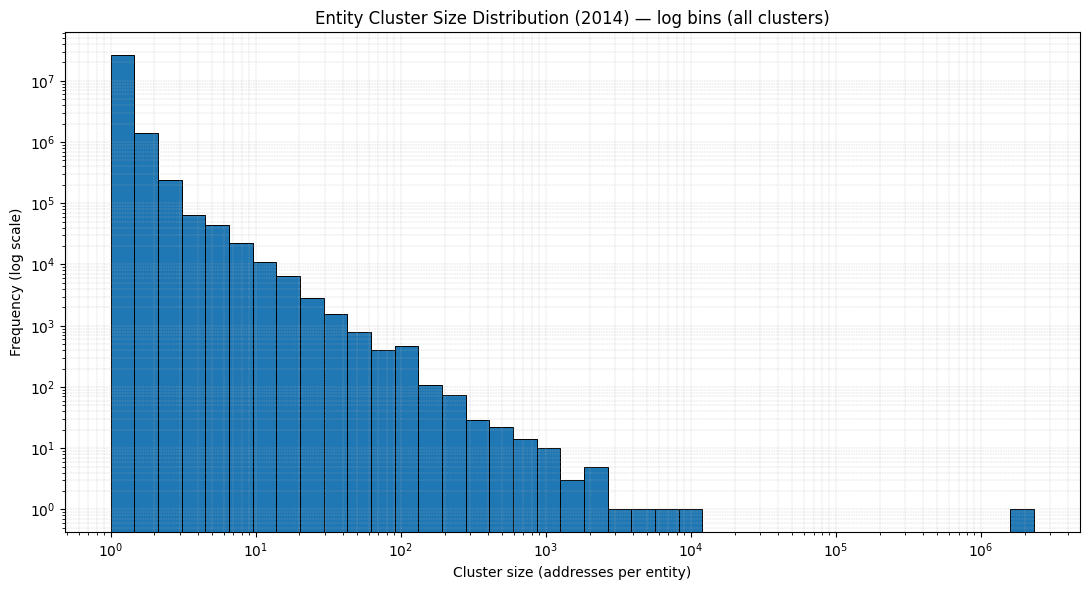

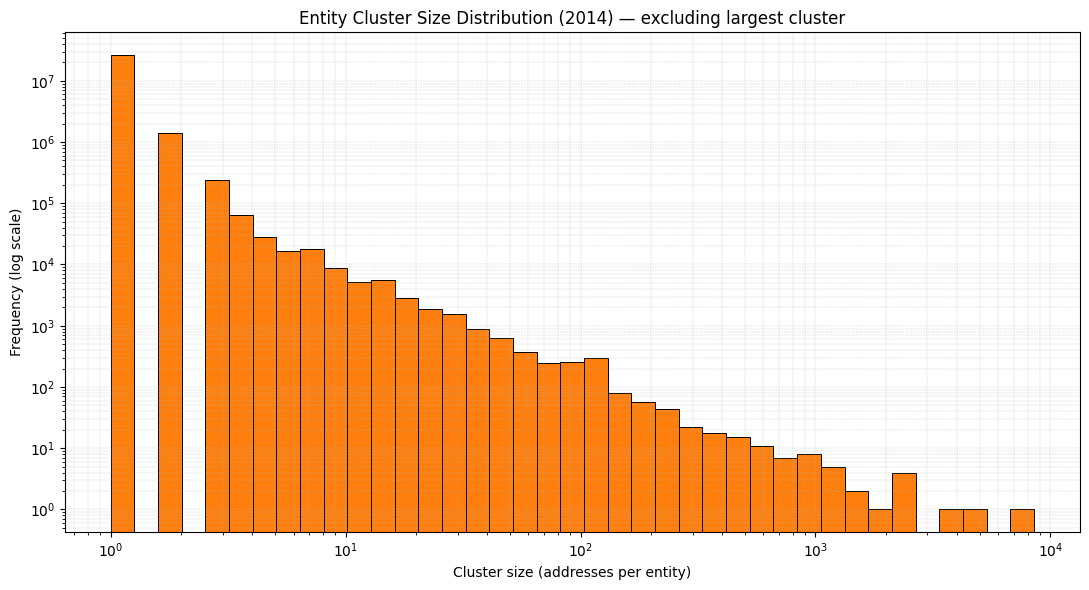

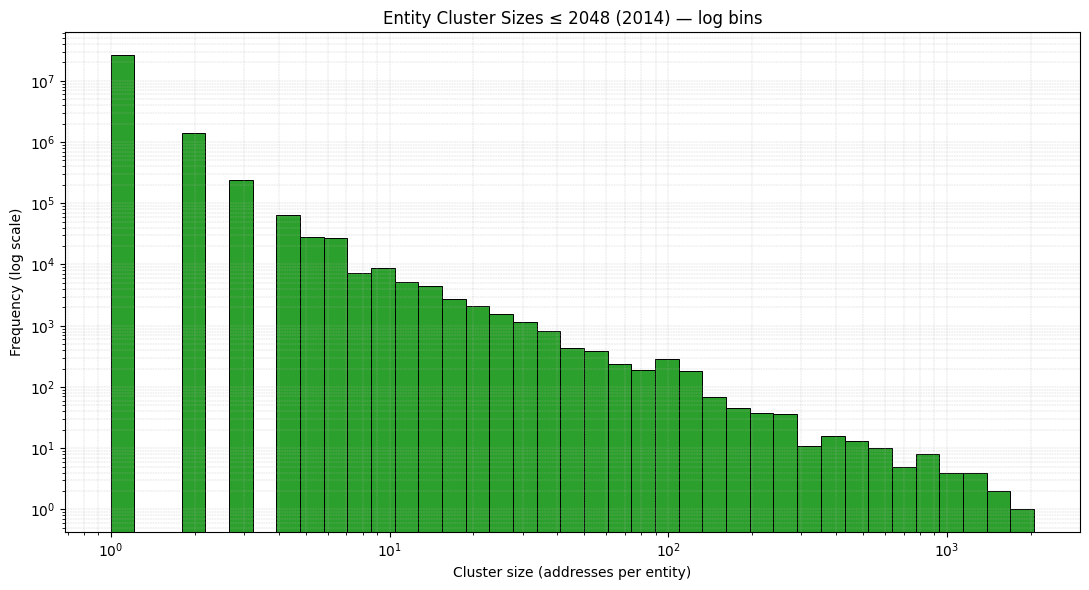

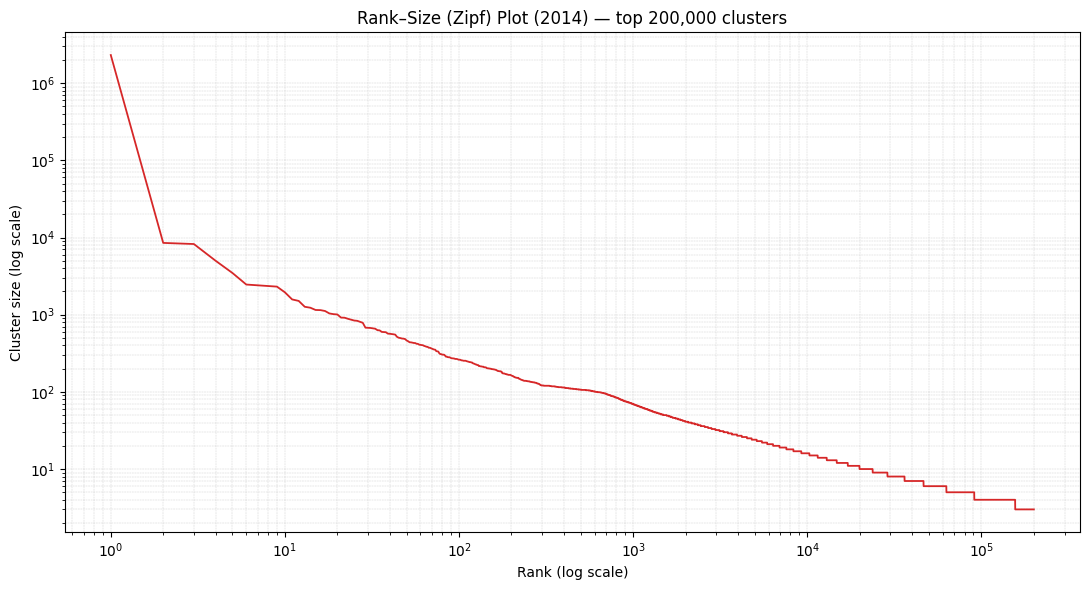

[INFO] Done.


In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from __future__ import annotations

import gc
import glob
import math
import os
import random
import sqlite3
import sys
from collections import Counter
from dataclasses import dataclass
from datetime import date, timedelta
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm.auto import tqdm


# =============================================================================
# Determinism helpers
# =============================================================================

def set_determinism(seed: int) -> None:
    """
    Makes the pipeline *more reproducible* across runs.

    Notes:
      - This pipeline is fundamentally deterministic given a deterministic stream order.
      - The main nondeterminism you observed comes from:
          * SQLite group_concat(DISTINCT ...) ordering (fixed by sorting lists post-transport)
          * Polars unique() order (fixed by sorting before insertion)
      - We still set seeds and env to reduce incidental variation.
    """
    os.environ.setdefault("PYTHONHASHSEED", str(seed))
    random.seed(seed)
    np.random.seed(seed)


# =============================================================================
# Config objects (NO DEFAULTS — everything must be explicit)
# =============================================================================

ValueUnitMode = Literal["infer", "btc", "sats"]
MultiInputPolicy = Literal["one_output", "one_or_two_nonmix"]


@dataclass(frozen=True)
class PathsConfig:
    parquet_io_glob: str
    outputs_dir: Path
    outpoint_db_path: Path
    entity_map_out_path: Path


@dataclass(frozen=True)
class AnalysisConfig:
    analysis_start: date
    analysis_end_exclusive: date
    outpoint_db_lookback_days: int
    value_unit_mode: ValueUnitMode


@dataclass(frozen=True)
class OutputConfig:
    reset_outpoint_db: bool
    write_entity_mapping: bool
    entity_map_compression: str
    entity_write_batch: int
    top_k_clusters_print: int


@dataclass(frozen=True)
class PlotConfig:
    enable_plots: bool
    zipf_top_k: int
    focus_max_size: int
    log_bins: int


@dataclass(frozen=True)
class PerfConfig:
    outpoint_commit_every_rows: int
    prevout_hybrid_threshold: int
    prevout_lookup_chunk: int
    iter_buffer_in: int
    iter_buffer_out: int
    iter_buffer_grouped: int
    gc_every_n_files: int
    tqdm_mininterval: float
    tqdm_miniters: int
    tqdm_postfix_every: int

    # Patch 3: set-based prevout join path (SQLite join + SQLite aggregates + Polars transport)
    use_sql_prevout_join: bool
    vinbuf_insert_chunk: int
    vinbuf_fetch_chunk: int


@dataclass(frozen=True)
class SanityConfig:
    run_sanity_checks: bool
    run_prevout_db_sanity: bool
    prevout_sanity_sample_limit: int
    prevout_sanity_parquet: str | None


@dataclass(frozen=True)
class HeuristicToggles:
    enable_coinjoin_filter: bool
    enable_multi_input: bool
    enable_change: bool
    enable_merge_guards: bool
    precreate_nodes_for_all_output_addrs: bool
    create_nodes_for_all_resolved_inputs: bool


@dataclass(frozen=True)
class HeuristicParams:
    dust_sats: int
    max_fee_abs_sats: int
    max_fee_frac: float
    max_change_inputs_utxos: int
    max_change_spendable_outs: int
    change_require_2_outputs: bool
    multi_input_policy: MultiInputPolicy
    enable_optimal_change_constraint: bool
    optimal_change_slack_sats: int


UltraVoteRule = tuple[int, int]  # (threshold, votes_required)


@dataclass(frozen=True)
class MergeGuardParams:
    # Safety ceiling (Patch 1: can be raised for mega-entities)
    max_merged_component_size: int

    # Ratio guard (CHANGE only) + Patch 1: ignore tiny components (singleton change)
    merge_ratio_guard: bool
    merge_ratio_max: float
    merge_ratio_big_cluster_min: int
    merge_ratio_small_floor: int

    # Big–big gating (CHANGE only): require multiple "confirmations" per component-pair
    enable_change_merge_votes: bool
    change_vote_min_side: int
    change_vote_merged_trigger: int
    change_votes_required: int

    # Patch 1: ultra-large strengthening (increases required votes above thresholds)
    ultra_change_vote_rules: tuple[UltraVoteRule, ...]

    # Diagnostics: ratio-guard sample log
    ratio_guard_sample_n: int
    ratio_guard_sample_path: Path

    # Patch 2: constraint (vote-gating) event log
    constraint_log_n: int
    constraint_log_path: Path

    # Debug logging of large merges (optional)
    debug_large_change_merges: bool
    debug_change_merge_min: int
    debug_change_merge_log_path: Path


@dataclass(frozen=True)
class ConfidenceConfig:
    """
    Proxy "probability" that an address is *meaningfully clustered* (diagnostic / downstream weight).
    This does NOT claim statistical calibration; it's an evidence-based score in [0,1].
    """
    enable_confidence_proxy: bool
    confidence_out_path: Path
    confidence_compression: str
    confidence_write_batch: int

    # scoring knobs
    size_norm: int               # saturates size_bonus around this cluster size
    size_bonus_max: float        # max additive bonus from cluster size
    p_singleton: float           # proxy for singleton clusters
    p_base_0: float              # base for clustered addr with 0 evidence bits (should be rare)
    p_base_1: float              # base for 1 evidence bit
    p_base_2plus: float          # base for >=2 evidence bits

    include_cluster_size: bool
    include_evidence_bits: bool


# =============================================================================
# Utility helpers
# =============================================================================

def extract_day_from_path(path: str) -> date | None:
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


def addr_type(addr: str) -> str:
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def infer_value_unit_from_sample(sample_vals: list[float]) -> str:
    if not sample_vals:
        return "btc"
    mx = max(sample_vals)
    return "sats" if mx >= 1e6 else "btc"


class UnionFind:
    """Union-Find with rank, path compression, and component sizes."""
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []
        self.size: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        self.size.append(1)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union_roots(self, rx: int, ry: int) -> int:
        if rx == ry:
            return rx
        parent = self.parent
        rank = self.rank
        size = self.size
        if rank[rx] < rank[ry]:
            parent[rx] = ry
            size[ry] += size[rx]
            return ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
            size[rx] += size[ry]
            return rx
        else:
            parent[ry] = rx
            rank[rx] += 1
            size[rx] += size[ry]
            return rx


def _count_dupe_values(values: list[int], dust_sats: int) -> tuple[int, int]:
    vals = [v for v in values if v >= dust_sats]
    if not vals:
        return 0, 0
    cnt = Counter(vals)
    return max(cnt.values()), len(cnt)


def detect_mixing_like(n_in_utxos: int, spendable_outs: list[tuple[str, int]], dust_sats: int) -> bool:
    # Conservative "mixing-like" flags: equal-amount patterns and symmetry.
    n_out = len(spendable_outs)
    if n_in_utxos < 3 or n_out < 3:
        return False

    out_vals = [v for (_a, v) in spendable_outs]
    out_types = [addr_type(a) for (a, _v) in spendable_outs if a is not None]
    unique_vals = len(set(out_vals))
    unique_types = len(set(out_types)) if out_types else 0
    max_dupe, distinct_vals_non_dust = _count_dupe_values(out_vals, dust_sats)

    if max_dupe >= 2 and distinct_vals_non_dust >= 2:
        return True
    if abs(n_in_utxos - n_out) <= 1 and min(n_in_utxos, n_out) >= 3:
        return True
    if n_out >= 4 and unique_vals <= (n_out // 2):
        return True
    if n_out >= 4 and unique_types == 1 and max_dupe >= 2:
        return True
    return False


def multi_input_is_safe(policy: MultiInputPolicy, n_in_utxos: int, n_spendable_out: int, is_mixing_like: bool) -> bool:
    if n_in_utxos < 2:
        return False
    if policy == "one_output":
        return n_spendable_out == 1
    if policy == "one_or_two_nonmix":
        if n_spendable_out == 1:
            return True
        if n_spendable_out == 2 and not is_mixing_like:
            return True
        return False
    raise ValueError(f"Unknown multi_input_policy={policy}")


# =============================================================================
# SQLite outpoint DB + TEMP join buffers
# =============================================================================

def open_outpoint_db(db_path: Path, reset: bool) -> sqlite3.Connection:
    if reset and db_path.exists():
        db_path.unlink()

    conn = sqlite3.connect(str(db_path))
    cur = conn.cursor()

    cur.execute("PRAGMA journal_mode=WAL;")
    cur.execute("PRAGMA synchronous=OFF;")
    cur.execute("PRAGMA temp_store=MEMORY;")
    cur.execute("PRAGMA cache_size=-2000000;")   # ~2GB cache (negative => KB)
    cur.execute("PRAGMA wal_autocheckpoint=5000;")

    conn.isolation_level = None
    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS outpoints (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL,
            address TEXT NOT NULL,
            value_sats INTEGER NOT NULL,
            PRIMARY KEY(txid, n)
        ) WITHOUT ROWID;
        """
    )
    return conn


def init_lookup_tables(conn: sqlite3.Connection) -> None:
    cur = conn.cursor()

    cur.execute("DROP TABLE IF EXISTS keybuf;")
    cur.execute(
        """
        CREATE TEMP TABLE keybuf (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL
        );
        """
    )

    cur.execute("DROP TABLE IF EXISTS vinbuf;")
    cur.execute(
        """
        CREATE TEMP TABLE vinbuf (
            spend_txid TEXT NOT NULL,
            prev_txid  TEXT NOT NULL,
            prev_n     INTEGER NOT NULL
        );
        """
    )


def reset_vinbuf(conn: sqlite3.Connection) -> None:
    conn.execute("DELETE FROM vinbuf;")


def insert_outpoints_no_commit(conn: sqlite3.Connection, rows: list[tuple[str, int, str, int]]) -> None:
    if rows:
        conn.executemany(
            "INSERT OR IGNORE INTO outpoints(txid, n, address, value_sats) VALUES (?, ?, ?, ?);",
            rows,
        )


# Legacy hybrid lookup kept for sanity check helper
def lookup_outpoints_or(conn: sqlite3.Connection, keys: list[tuple[str, int]], chunk_size: int) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))
    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]
        where = " OR ".join(["(txid=? AND n=?)"] * len(chunk))
        params = [p for k in chunk for p in k]
        cur.execute(f"SELECT txid, n, address, value_sats FROM outpoints WHERE {where};", params)
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))
    return out


def lookup_outpoints_join(conn: sqlite3.Connection, keys: list[tuple[str, int]], chunk_size: int) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))
    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]
        cur.execute("DELETE FROM keybuf;")
        cur.executemany("INSERT INTO keybuf(txid, n) VALUES (?, ?);", chunk)
        cur.execute(
            """
            SELECT k.txid, k.n, o.address, o.value_sats
            FROM keybuf k
            JOIN outpoints o
              ON o.txid = k.txid AND o.n = k.n;
            """
        )
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))
    return out


def lookup_outpoints_hybrid(conn: sqlite3.Connection, keys: list[tuple[str, int]], hybrid_threshold: int, join_chunk: int) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    if len(keys) < hybrid_threshold:
        return lookup_outpoints_or(conn, keys, chunk_size=500)
    return lookup_outpoints_join(conn, keys, chunk_size=join_chunk)


# =============================================================================
# Patch 3: Resolve + aggregate inputs inside SQLite, transport to Polars
# =============================================================================

def fetch_prevouts_aggs_polars(conn: sqlite3.Connection, fetch_chunk: int) -> pl.DataFrame:
    """
    Returns one row per spend_txid:

      txid: str
      resolved_cnt: int
      sum_inputs_sats: int
      min_input_sats: int
      in_addrs: list[str]   (DISTINCT addresses among resolved inputs for that tx)

    Note: group_concat() uses commas; Bitcoin addresses do not contain commas.
    """
    cur = conn.cursor()
    cur.execute(
        """
        SELECT
            v.spend_txid                                 AS txid,
            COUNT(*)                                      AS resolved_cnt,
            SUM(o.value_sats)                             AS sum_inputs_sats,
            MIN(o.value_sats)                             AS min_input_sats,
            group_concat(DISTINCT o.address)              AS in_addrs_csv
        FROM vinbuf v
        JOIN outpoints o
          ON o.txid = v.prev_txid AND o.n = v.prev_n
        GROUP BY v.spend_txid;
        """
    )

    dfs: list[pl.DataFrame] = []
    while True:
        rows = cur.fetchmany(fetch_chunk)
        if not rows:
            break
        dfs.append(
            pl.DataFrame(
                rows,
                schema=["txid", "resolved_cnt", "sum_inputs_sats", "min_input_sats", "in_addrs_csv"],
                orient="row",
            )
        )

    if not dfs:
        return pl.DataFrame(
            schema={
                "txid": pl.Utf8,
                "resolved_cnt": pl.Int64,
                "sum_inputs_sats": pl.Int64,
                "min_input_sats": pl.Int64,
                "in_addrs": pl.List(pl.Utf8),
            }
        )

    df = pl.concat(dfs, how="vertical", rechunk=True)

    df = df.with_columns(
        pl.col("in_addrs_csv")
        .fill_null("")
        .str.split(",")
        .alias("in_addrs")
    ).drop("in_addrs_csv")

    # Edge-case: NULL -> "" -> [""] should become []
    df = df.with_columns(
        pl.when(pl.col("in_addrs") == [""])
        .then(pl.lit([], dtype=pl.List(pl.Utf8)))
        .otherwise(pl.col("in_addrs"))
        .alias("in_addrs")
    )

    # Determinism: sort the per-tx list of input addresses
    df = df.with_columns(pl.col("in_addrs").list.sort().alias("in_addrs"))

    return df


# =============================================================================
# Sanity checks
# =============================================================================

def run_sanity_checks(
    n_nodes: int,
    node_to_entity: np.ndarray,
    prevout_lookups: int,
    prevout_hits: int,
    top_k: int,
) -> None:
    cluster_size_counter = Counter(list(node_to_entity))
    sizes = list(cluster_size_counter.values())
    if not sizes:
        print("[SANITY] No clusters found.", flush=True)
        return
    sizes_sorted = sorted(sizes, reverse=True)
    total = sum(sizes_sorted)
    largest = sizes_sorted[0]
    frac = largest / total if total else float("nan")

    print("\n[SANITY] Cluster summary", flush=True)
    print(f"  UF nodes (n_nodes): {n_nodes:,}", flush=True)
    print(f"  Total nodes from cluster sizes: {total:,}", flush=True)
    print(f"  Entities (clusters): {len(cluster_size_counter):,}", flush=True)
    print(f"  Largest cluster size: {largest:,}", flush=True)
    print(f"  Largest cluster fraction of nodes: {frac:.2%}", flush=True)
    print(f"\n[SANITY] Top {top_k} cluster sizes:", flush=True)
    print(" ", sizes_sorted[:top_k], flush=True)

    s_asc = sorted(sizes_sorted)
    med = int(s_asc[len(s_asc) // 2])
    p90 = int(s_asc[max(0, math.ceil(0.90 * len(s_asc)) - 1)])
    p99 = int(s_asc[max(0, math.ceil(0.99 * len(s_asc)) - 1)])
    print("\n[SANITY] Quick distribution stats", flush=True)
    print(f"  Median cluster size: {med:,}", flush=True)
    print(f"  90th percentile cluster size: {p90:,}", flush=True)
    print(f"  99th percentile cluster size: {p99:,}", flush=True)

    rate = (prevout_hits / prevout_lookups) if prevout_lookups else float("nan")
    print("\n[SANITY] Prevout lookup hit-rate (DB)", flush=True)
    print(f"  Lookups:  {prevout_lookups:,}", flush=True)
    print(f"  Hits:     {prevout_hits:,}", flush=True)
    print(f"  Hit-rate: {rate:.2%}", flush=True)


def prevout_join_sanity_db(conn: sqlite3.Connection, parquet_path: str, sample_limit: int, hybrid_threshold: int, join_chunk: int) -> None:
    df = pl.read_parquet(parquet_path, columns=["dir", "txid", "prev_txid", "prev_vout"])
    df = df.with_columns(pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().alias("dir"))
    vin = (
        df.filter(pl.col("dir") == "in")
        .select([pl.col("txid").alias("spend_txid"), "prev_txid", "prev_vout"])
        .filter(pl.col("prev_txid").is_not_null() & pl.col("prev_vout").is_not_null())
        .head(sample_limit)
    )
    print("\n[PREVOUT-SANITY | DB]", flush=True)
    print("File:", parquet_path, flush=True)
    print("Vin sample rows:", vin.height, flush=True)
    if vin.height == 0:
        return

    vin2 = vin.with_columns(pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_vout_i64")).filter(
        pl.col("prev_vout_i64").is_not_null()
    )

    keys = [(tx, int(n)) for tx, n in vin2.select(["prev_txid", "prev_vout_i64"]).iter_rows(named=False, buffer_size=200_000)]
    hits = lookup_outpoints_hybrid(conn, keys, hybrid_threshold=hybrid_threshold, join_chunk=join_chunk)
    print(f"DB prevout hit-rate (sample): {len(hits)}/{len(keys)} = {len(hits)/len(keys):.2%}" if keys else "No keys", flush=True)


# =============================================================================
# Plot helpers
# =============================================================================

def _log_bins(max_val: int, bins: int) -> np.ndarray:
    max_val = max(1, int(max_val))
    return np.logspace(0, math.log10(max_val), num=bins)


def plot_hist_logbins(sizes: np.ndarray, title: str, color: str, bins: int, max_x: int | None) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}", flush=True)
        return
    if max_x is None:
        max_x = int(sizes.max())
    b = _log_bins(max_x, bins)
    plt.figure(figsize=(11, 6))
    plt.hist(sizes, bins=b, log=True, color=color, edgecolor="black", linewidth=0.7)
    plt.xscale("log")
    plt.xlabel("Cluster size (addresses per entity)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


def plot_zipf(sizes: np.ndarray, title: str, color: str, top_k: int) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}", flush=True)
        return
    top_k = min(top_k, sizes.size)
    top = np.partition(sizes, -top_k)[-top_k:]
    top_sorted = np.sort(top)[::-1]
    ranks = np.arange(1, top_sorted.size + 1)

    plt.figure(figsize=(11, 6))
    plt.plot(ranks, top_sorted, color=color, linewidth=1.3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Cluster size (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


# =============================================================================
# Main executor (explicit-parameter entrypoint)
# =============================================================================

def run_entity_clustering(
    paths: PathsConfig,
    analysis: AnalysisConfig,
    outputs: OutputConfig,
    plots: PlotConfig,
    perf: PerfConfig,
    sanity: SanityConfig,
    toggles: HeuristicToggles,
    params: HeuristicParams,
    guards: MergeGuardParams,
    confidence: ConfidenceConfig,
    *,
    determinism_seed: int,
) -> None:
    """
    Address clustering with:
      - H1 multi-input heuristic under a configurable safety policy
      - Change heuristic (2-output default, optional 3-output)
      - Mixing-like filter
      - Merge guards:
          * absolute max component size (all unions)
          * ratio guard ONLY for CHANGE unions (+ small-floor to avoid freezing on singletons)
          * big–big vote-gating with ultra-large strengthening
      - Patch 3:
          * prevout resolution via set-based SQLite JOIN (vinbuf → outpoints)
          * per-tx input aggregates computed in SQLite, transported to Polars
      - Node universe patch PRESERVED:
          * create UF nodes for all resolved input addresses (toggle)
      - Diagnostics:
          * skip reason counters
          * ratio-guard sample log
          * constraint (vote-gating) event log (Patch 2)
      - Confidence proxy output (optional):
          * address → proxy score based on heuristic evidence + component size
    """
    set_determinism(determinism_seed)

    # stdout/stderr line-buffered where supported (helps when redirected).
    try:
        sys.stdout.reconfigure(line_buffering=True)
        sys.stderr.reconfigure(line_buffering=True)
    except Exception:
        pass

    pl.Config.set_tbl_rows(20)
    pl.Config.set_fmt_str_lengths(80)

    paths.outputs_dir.mkdir(parents=True, exist_ok=True)

    io_paths = sorted(glob.glob(paths.parquet_io_glob))
    print("Parquet file counts:", {"io": len(io_paths)}, flush=True)
    print(f"[INFO] Analysis window: {analysis.analysis_start} .. {analysis.analysis_end_exclusive} (exclusive)", flush=True)

    index_start = analysis.analysis_start - timedelta(days=analysis.outpoint_db_lookback_days)
    print(f"[INFO] Outpoint DB preload start: {index_start} .. {analysis.analysis_end_exclusive} (exclusive)", flush=True)
    print(f"[INFO] Outpoint DB path: {paths.outpoint_db_path} (reset={outputs.reset_outpoint_db})", flush=True)

    eligible: list[tuple[str, date]] = []
    for path in io_paths:
        d = extract_day_from_path(path)
        if d is None:
            continue
        if index_start <= d < analysis.analysis_end_exclusive:
            eligible.append((path, d))

    n_preload_total = sum(1 for _p, d in eligible if d < analysis.analysis_start)
    n_analysis_total = len(eligible) - n_preload_total
    print(f"[INFO] Eligible files in window: {len(eligible)}  (preload={n_preload_total}, analysis={n_analysis_total})", flush=True)

    if not eligible:
        print("[WARN] No eligible parquet files found for the requested window.", flush=True)
        return

    # Pick sanity parquet
    sanity_parquet = sanity.prevout_sanity_parquet
    if sanity_parquet is None:
        for p, d in eligible:
            if analysis.analysis_start <= d < analysis.analysis_end_exclusive:
                sanity_parquet = p
                break
        if sanity_parquet is None and eligible:
            sanity_parquet = eligible[0][0]
    if sanity.run_sanity_checks and sanity_parquet:
        print(f"[INFO] Sanity parquet selected: {sanity_parquet}", flush=True)

    conn = open_outpoint_db(paths.outpoint_db_path, reset=outputs.reset_outpoint_db)
    init_lookup_tables(conn)

    conn.execute("BEGIN;")
    pending_outpoint_rows = 0

    uf = UnionFind()
    addr_to_id: dict[str, int] = {}

    # Flags (diagnostic, no behavior)
    # bit 1: multi-input evidence
    # bit 2: change-output evidence (address was the change output)
    # bit 4: change-anchor evidence (address was the input anchor merged to change)
    multi_change_flags = bytearray()
    seen_output_flags = bytearray()

    seen_output_addrs: set[str] | None
    if toggles.precreate_nodes_for_all_output_addrs:
        seen_output_addrs = None
    else:
        seen_output_addrs = set()

    def ensure_flag_capacity(idx: int) -> None:
        needed = idx + 1
        cur = len(seen_output_flags)
        if cur < needed:
            delta = needed - cur
            seen_output_flags.extend(b"\x00" * delta)
            multi_change_flags.extend(b"\x00" * delta)

    def get_addr_id(addr: str) -> int:
        idx = addr_to_id.get(addr)
        if idx is None:
            idx = uf.make_set()
            addr_to_id[addr] = idx
            ensure_flag_capacity(idx)
        return idx

    # value unit mode
    if analysis.value_unit_mode == "btc":
        value_unit: str | None = "btc"
    elif analysis.value_unit_mode == "sats":
        value_unit = "sats"
    elif analysis.value_unit_mode == "infer":
        value_unit = None
    else:
        raise ValueError(f"Unknown value_unit_mode={analysis.value_unit_mode}")

    def value_expr_to_sats() -> pl.Expr:
        nonlocal value_unit
        if value_unit is None:
            return (pl.col("value").cast(pl.Float64, strict=False) * 100_000_000).round(0).cast(pl.Int64, strict=False)
        if value_unit == "sats":
            return pl.col("value").cast(pl.Float64, strict=False).round(0).cast(pl.Int64, strict=False)
        return (pl.col("value").cast(pl.Float64, strict=False) * 100_000_000).round(0).cast(pl.Int64, strict=False)

    stats = {
        "n_files_indexed": 0,
        "n_files_analyzed": 0,
        "n_txs_total": 0,
        "n_txs_coinjoin_flagged": 0,
        "n_txs_with_multiinput": 0,
        "n_txs_with_change_detected": 0,
        "n_prevout_lookups": 0,
        "n_prevout_hits": 0,  # counts resolved INPUT UTXOs

        "union_attempts": 0,
        "unions_applied": 0,
        "unions_applied_h1": 0,
        "unions_applied_change": 0,

        "skip_same_component": 0,
        "skip_same_component_h1": 0,
        "skip_same_component_change": 0,

        "unions_skipped": 0,  # guard/votes/constraints
        "unions_skipped_h1": 0,
        "unions_skipped_change": 0,

        "skip_abs_cap": 0,
        "skip_abs_cap_h1": 0,
        "skip_abs_cap_change": 0,

        "skip_ratio_guard": 0,
        "skip_ratio_guard_change": 0,

        "skip_constraint": 0,            # big–big gating (votes not yet satisfied)
        "skip_constraint_change": 0,

        "skip_vote_pending": 0,
        "skip_vote_failed": 0,
    }

    # vote-gating store (keyed by unordered (root_a, root_b))
    change_merge_votes: dict[tuple[int, int], int] = {}

    # constraint diagnostics (Patch 2)
    constraints_added = 0  # number of unique pairs that ever triggered gating
    constraint_events_total = 0
    constraint_events_unique_pairs: set[tuple[int, int]] = set()

    # ratio-guard sample log state
    ratio_guard_samples_written = 0
    ratio_guard_sample_fh = None
    try:
        if guards.ratio_guard_sample_n > 0:
            ratio_guard_sample_fh = open(guards.ratio_guard_sample_path, "w", encoding="utf-8")
            ratio_guard_sample_fh.write(
                "txid\tsa\tsb\ts_big\ts_small\tratio\tchange_side\tbig_side\tbig_is_change\tchange_comp_size\tinput_comp_size\n"
            )
    except Exception:
        ratio_guard_sample_fh = None

    # constraint log state (Patch 2)
    constraint_log_written = 0
    constraint_log_fh = None
    try:
        if guards.constraint_log_n > 0:
            constraint_log_fh = open(guards.constraint_log_path, "w", encoding="utf-8")
            constraint_log_fh.write(
                "txid\tsa\tsb\tmerged\tmin_side\tbig_side\tvotes\tvotes_required\tkey_r0\tkey_r1\ttriggered_by\tbig_is_change\n"
            )
    except Exception:
        constraint_log_fh = None

    def _votes_required_for_sizes(min_side: int, big_side: int, merged: int) -> int:
        req = guards.change_votes_required
        # ultra rules: apply max requirement among triggered thresholds
        # threshold triggers on big_side OR merged (conservative)
        for thr, req_thr in guards.ultra_change_vote_rules:
            if big_side >= thr or merged >= thr:
                if req_thr > req:
                    req = req_thr
        return req

    def union_guarded(a: int, b: int, reason: Literal["H1", "CHANGE"], txid: str | None) -> bool:
        # FIX: counters are in the outer scope; += requires nonlocal
        nonlocal ratio_guard_samples_written, constraint_log_written, constraints_added, constraint_events_total

        stats["union_attempts"] += 1
        ra = uf.find(a)
        rb = uf.find(b)
        if ra == rb:
            stats["skip_same_component"] += 1
            if reason == "H1":
                stats["skip_same_component_h1"] += 1
            else:
                stats["skip_same_component_change"] += 1
            return False

        sa = uf.size[ra]
        sb = uf.size[rb]
        merged = sa + sb

        # No guards path
        if not toggles.enable_merge_guards:
            uf.union_roots(ra, rb)
            stats["unions_applied"] += 1
            if reason == "H1":
                stats["unions_applied_h1"] += 1
            else:
                stats["unions_applied_change"] += 1
            return True

        # Absolute cap (all unions)
        if merged > guards.max_merged_component_size:
            stats["unions_skipped"] += 1
            if reason == "H1":
                stats["unions_skipped_h1"] += 1
                stats["skip_abs_cap_h1"] += 1
            else:
                stats["unions_skipped_change"] += 1
                stats["skip_abs_cap_change"] += 1
            stats["skip_abs_cap"] += 1
            return False

        # Ratio guard ONLY for CHANGE (with small-floor to avoid freezing singleton change attachments)
        if guards.merge_ratio_guard and reason == "CHANGE":
            s_big = sa if sa >= sb else sb
            s_small = sb if sa >= sb else sa

            if s_small >= guards.merge_ratio_small_floor and s_big >= guards.merge_ratio_big_cluster_min:
                ratio = (s_big / s_small) if s_small > 0 else float("inf")
                if ratio > guards.merge_ratio_max:
                    stats["unions_skipped"] += 1
                    stats["unions_skipped_change"] += 1
                    stats["skip_ratio_guard"] += 1
                    stats["skip_ratio_guard_change"] += 1

                    # Optional sample log (assumes CHANGE call is (input, change))
                    if (
                        ratio_guard_sample_fh is not None
                        and ratio_guard_samples_written < guards.ratio_guard_sample_n
                        and txid is not None
                    ):
                        # change side is b => rb; input side is a => ra
                        change_side = "b"
                        input_side = "a"
                        big_is_change = 1 if (rb == (ra if sa >= sb else rb) and s_big == sb) else 0

                        # More robust: decide big_is_change by comparing which root had big size
                        # If sa>=sb, big root is ra; else rb.
                        big_root = ra if sa >= sb else rb
                        big_is_change = 1 if big_root == rb else 0

                        ratio_guard_sample_fh.write(
                            f"{txid}\t{sa}\t{sb}\t{s_big}\t{s_small}\t{ratio}\t{change_side}\t"
                            f"{'b' if big_is_change else 'a'}\t{big_is_change}\t"
                            f"{sb if big_is_change else sa}\t{sa if big_is_change else sb}\n"
                        )
                        ratio_guard_samples_written += 1
                    return False

        # Big–big vote-gating ONLY for CHANGE (Patch 1 + Patch 2)
        if guards.enable_change_merge_votes and reason == "CHANGE":
            min_side = sa if sa <= sb else sb
            big_side = sa if sa >= sb else sb

            triggered = False
            triggered_by = None

            if guards.change_vote_min_side > 0 and min_side >= guards.change_vote_min_side:
                triggered = True
                triggered_by = "min_side"
            if (not triggered) and guards.change_vote_merged_trigger > 0 and merged >= guards.change_vote_merged_trigger:
                triggered = True
                triggered_by = "merged"

            if triggered:
                r0, r1 = (ra, rb) if ra < rb else (rb, ra)
                k = (r0, r1)

                prev = change_merge_votes.get(k, 0)
                if prev == 0:
                    constraints_added += 1
                    constraint_events_unique_pairs.add(k)

                change_merge_votes[k] = prev + 1

                votes_required = _votes_required_for_sizes(min_side=min_side, big_side=big_side, merged=merged)
                votes = change_merge_votes[k]

                if votes < votes_required:
                    stats["unions_skipped"] += 1
                    stats["unions_skipped_change"] += 1
                    stats["skip_constraint"] += 1
                    stats["skip_constraint_change"] += 1
                    constraint_events_total += 1

                    # Patch 2: log constraint events (first N)
                    if (
                        constraint_log_fh is not None
                        and constraint_log_written < guards.constraint_log_n
                        and txid is not None
                    ):
                        # in CHANGE, b is change address; big_is_change based on which root is big
                        big_root = ra if sa >= sb else rb
                        big_is_change = 1 if big_root == rb else 0
                        constraint_log_fh.write(
                            f"{txid}\t{sa}\t{sb}\t{merged}\t{min_side}\t{big_side}\t"
                            f"{votes}\t{votes_required}\t{r0}\t{r1}\t{triggered_by}\t{big_is_change}\n"
                        )
                        constraint_log_written += 1
                    return False

        # Debug log of large CHANGE merges that pass all guards (optional)
        if guards.debug_large_change_merges and reason == "CHANGE" and merged >= guards.debug_change_merge_min and txid is not None:
            try:
                with open(guards.debug_change_merge_log_path, "a", encoding="utf-8") as f:
                    f.write(f"{txid}\t{sa}\t{sb}\t{merged}\n")
            except Exception:
                pass

        # Apply union
        uf.union_roots(ra, rb)
        stats["unions_applied"] += 1
        if reason == "H1":
            stats["unions_applied_h1"] += 1
        else:
            stats["unions_applied_change"] += 1
        return True

    # tqdm: force stdout so it appears when stderr isn't shown/captured
    pbar = tqdm(
        eligible,
        total=len(eligible),
        unit="file",
        dynamic_ncols=True,
        mininterval=perf.tqdm_mininterval,
        miniters=perf.tqdm_miniters,
        smoothing=0,
        desc="Processing parquet",
        file=sys.stdout,
        leave=True,
    )

    DIR_NEEDS_NORMALIZATION: bool | None = None

    def log(msg: str) -> None:
        tqdm.write(msg, file=sys.stdout)

    def mark_outputs_seen(outputs_list: list[tuple[str | None, int]]) -> None:
        if toggles.precreate_nodes_for_all_output_addrs:
            for a, _v in outputs_list:
                if a is None:
                    continue
                a_id = get_addr_id(a)
                seen_output_flags[a_id] = 1
        else:
            assert seen_output_addrs is not None
            for a, _v in outputs_list:
                if a is not None:
                    seen_output_addrs.add(a)

    for i, (path, file_day) in enumerate(pbar, start=1):
        in_analysis = (analysis.analysis_start <= file_day < analysis.analysis_end_exclusive)

        if (i % perf.tqdm_postfix_every) == 0:
            pbar.set_postfix_str(f"{'analysis' if in_analysis else 'preload'} day={file_day}")

        if in_analysis:
            stats["n_files_analyzed"] += 1
            if stats["n_files_analyzed"] <= 5:
                log(f"[{stats['n_files_analyzed']}] Processing {path} (day={file_day}) ...")
            elif (stats["n_files_analyzed"] % 250) == 0:
                log(f"[{stats['n_files_analyzed']}] Processing ... (day={file_day})")
        else:
            stats["n_files_indexed"] += 1
            if stats["n_files_indexed"] <= 3:
                log(f"[preload {stats['n_files_indexed']}] Indexing outputs only: {path} (day={file_day}) ...")

        df = pl.read_parquet(path, columns=["dir", "txid", "n", "prev_txid", "prev_vout", "address", "value"])

        if DIR_NEEDS_NORMALIZATION is None:
            dir_uniques = df.select(pl.col("dir").cast(pl.Utf8, strict=False).unique()).to_series().to_list()
            DIR_NEEDS_NORMALIZATION = any(
                (d is not None and str(d).lower() in ("in", "out") and str(d) not in ("in", "out")) for d in dir_uniques
            )
            if in_analysis and stats["n_files_analyzed"] == 1:
                log(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

        if DIR_NEEDS_NORMALIZATION:
            df = df.with_columns(pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir"))

        # Infer unit once if needed
        if value_unit is None:
            sample = (
                df.filter(pl.col("dir") == "out")
                .select(pl.col("value").cast(pl.Float64, strict=False))
                .drop_nulls()
                .head(5000)
                .to_series()
                .to_list()
            )
            value_unit = infer_value_unit_from_sample(sample)
            log(f"[INFO] Detected value unit: {value_unit}  (all internal amount logic uses satoshis)")

        # 1) Index outputs into outpoints DB
        out_all = (
            df.filter(pl.col("dir") == "out")
            .filter(pl.col("txid").is_not_null())
            .filter(pl.col("n").is_not_null())
            .select(
                pl.col("txid"),
                pl.col("n").cast(pl.Int64, strict=False).alias("n"),
                pl.col("address"),
                value_expr_to_sats().alias("value_sats"),
            )
        )

        out_for_db = out_all.filter(pl.col("address").is_not_null()).filter(pl.col("value_sats").is_not_null())
        if out_for_db.height > 0:
            rows = [
                (txid, int(n), addr, int(vs))
                for txid, n, addr, vs in out_for_db.select(["txid", "n", "address", "value_sats"]).iter_rows(
                    named=False, buffer_size=perf.iter_buffer_out
                )
            ]
            insert_outpoints_no_commit(conn, rows)
            pending_outpoint_rows += len(rows)

            if pending_outpoint_rows >= perf.outpoint_commit_every_rows:
                conn.execute("COMMIT;")
                conn.execute("BEGIN;")
                pending_outpoint_rows = 0

            if toggles.precreate_nodes_for_all_output_addrs:
                # Determinism: sort unique output addrs before node creation
                out_u = out_for_db.select(pl.col("address").unique()).to_series().to_list()
                for addr in sorted(out_u):
                    _ = get_addr_id(addr)

        if not in_analysis:
            del df, out_all, out_for_db
            if (i % perf.gc_every_n_files) == 0:
                gc.collect()
            continue

        # 2) Build VIN (spend_txid, prev_txid, prev_n)
        in_df = (
            df.filter(pl.col("dir") == "in")
            .filter(pl.col("txid").is_not_null())
            .filter(pl.col("prev_txid").is_not_null())
            .filter(pl.col("prev_vout").is_not_null())
            .select(
                pl.col("txid").alias("spend_txid"),
                pl.col("prev_txid"),
                pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_n"),
            )
            .filter(pl.col("prev_n").is_not_null())
        )

        del df
        if (i % perf.gc_every_n_files) == 0:
            gc.collect()

        if in_df.height == 0:
            del in_df
            del out_all, out_for_db
            if (i % perf.gc_every_n_files) == 0:
                gc.collect()
            continue

        # n_in_utxos per spend tx (UTXO count, not unique addresses)
        in_counts = (
            in_df.group_by("spend_txid")
            .len()
            .rename({"spend_txid": "txid", "len": "n_in_utxos"})
        )

        # 2a) Resolve prevouts via SQLite join + SQLite aggregates
        if not perf.use_sql_prevout_join:
            raise RuntimeError("perf.use_sql_prevout_join=False is not supported in this build; set it True.")

        reset_vinbuf(conn)

        cur = conn.cursor()
        insert_sql = "INSERT INTO vinbuf(spend_txid, prev_txid, prev_n) VALUES (?, ?, ?);"
        batch: list[tuple[str, str, int]] = []
        total_vin = 0

        for spend_txid, prev_txid, prev_n in in_df.select(["spend_txid", "prev_txid", "prev_n"]).iter_rows(
            named=False, buffer_size=perf.iter_buffer_in
        ):
            batch.append((str(spend_txid), str(prev_txid), int(prev_n)))
            if len(batch) >= perf.vinbuf_insert_chunk:
                cur.executemany(insert_sql, batch)
                total_vin += len(batch)
                batch.clear()

        if batch:
            cur.executemany(insert_sql, batch)
            total_vin += len(batch)
            batch.clear()

        stats["n_prevout_lookups"] += total_vin

        resolved_aggs = fetch_prevouts_aggs_polars(conn, fetch_chunk=perf.vinbuf_fetch_chunk)

        # prevout hits = total resolved INPUT rows (sum of resolved_cnt)
        if resolved_aggs.height > 0:
            resolved_inputs_sum = resolved_aggs.select(pl.col("resolved_cnt").sum()).item()
            stats["n_prevout_hits"] += int(resolved_inputs_sum) if resolved_inputs_sum is not None else 0

        del in_df

        # Node universe patch: create nodes for ALL resolved input addresses
        if toggles.create_nodes_for_all_resolved_inputs and resolved_aggs.height > 0:
            u = (
                resolved_aggs
                .select(pl.col("in_addrs").explode().drop_nulls().unique())
                .to_series()
                .to_list()
            )
            # Determinism: sort before insertion
            for a in sorted(u):
                _ = get_addr_id(a)

        # 3) Outputs grouped per tx
        if out_all.height == 0:
            del out_all, out_for_db, in_counts, resolved_aggs
            if (i % perf.gc_every_n_files) == 0:
                gc.collect()
            continue

        vout_grouped = (
            out_all.group_by("txid")
            .agg(
                pl.col("address").alias("out_addrs_all"),
                pl.col("value_sats").alias("out_values_sats_all"),
            )
        )
        del out_all, out_for_db

        # Join tx-level inputs + resolved stats to outputs
        tx_joined = (
            vout_grouped
            .join(in_counts, on="txid", how="inner")
            .join(resolved_aggs, on="txid", how="left")
        )
        del vout_grouped, in_counts, resolved_aggs

        for (
            txid,
            out_addrs_all,
            out_values_all,
            n_in_utxos,
            resolved_cnt,
            sum_inputs_sats,
            min_input_sats,
            in_addrs,
        ) in tx_joined.select(
            ["txid", "out_addrs_all", "out_values_sats_all", "n_in_utxos", "resolved_cnt", "sum_inputs_sats", "min_input_sats", "in_addrs"]
        ).iter_rows(named=False, buffer_size=perf.iter_buffer_grouped):

            if not out_addrs_all or not out_values_all:
                continue

            n_in_utxos_i = int(n_in_utxos) if n_in_utxos is not None else 0
            if n_in_utxos_i == 0:
                continue

            stats["n_txs_total"] += 1

            outputs_list: list[tuple[str | None, int]] = []
            sum_outputs_sats = 0
            for a, v in zip(out_addrs_all, out_values_all):
                if v is None:
                    continue
                vi = int(v)
                outputs_list.append((a, vi))
                sum_outputs_sats += vi

            spendable = [(a, v) for (a, v) in outputs_list if a is not None and v >= params.dust_sats]
            if not spendable:
                mark_outputs_seen(outputs_list)
                continue

            # Mixing-like filter
            is_mixing_like = False
            if toggles.enable_coinjoin_filter:
                is_mixing_like = detect_mixing_like(n_in_utxos_i, spendable, dust_sats=params.dust_sats)
                if is_mixing_like:
                    stats["n_txs_coinjoin_flagged"] += 1
                    mark_outputs_seen(outputs_list)
                    continue

            if in_addrs is None:
                mark_outputs_seen(outputs_list)
                continue

            in_addrs_list = list(in_addrs)  # already list-sorted in fetch_prevouts_aggs_polars()
            if not in_addrs_list:
                mark_outputs_seen(outputs_list)
                continue

            # H1 multi-input unions
            if toggles.enable_multi_input:
                safe = multi_input_is_safe(params.multi_input_policy, n_in_utxos_i, len(spendable), is_mixing_like)
                if safe:
                    stats["n_txs_with_multiinput"] += 1
                    if len(in_addrs_list) >= 2:
                        in_ids = [get_addr_id(a) for a in in_addrs_list]
                        for idx in in_ids:
                            multi_change_flags[idx] |= 1  # multi-input evidence
                        first_id = in_ids[0]
                        for idx in in_ids[1:]:
                            union_guarded(first_id, idx, reason="H1", txid=str(txid))
                    else:
                        idx = get_addr_id(in_addrs_list[0])
                        multi_change_flags[idx] |= 1

            # CHANGE unions
            if toggles.enable_change:
                n_spendable_out = len(spendable)

                if params.change_require_2_outputs and n_spendable_out != 2:
                    mark_outputs_seen(outputs_list)
                    continue
                if n_in_utxos_i > params.max_change_inputs_utxos:
                    mark_outputs_seen(outputs_list)
                    continue
                if n_spendable_out > params.max_change_spendable_outs:
                    mark_outputs_seen(outputs_list)
                    continue

                resolved_cnt_i = int(resolved_cnt) if resolved_cnt is not None else 0
                if resolved_cnt_i != n_in_utxos_i:
                    mark_outputs_seen(outputs_list)
                    continue

                in_types = [addr_type(a) for a in in_addrs_list]
                if len(set(in_types)) != 1:
                    mark_outputs_seen(outputs_list)
                    continue
                majority_type = in_types[0]

                spendable_addrs = [a for (a, _v) in spendable]
                if len(spendable_addrs) != len(set(spendable_addrs)):
                    mark_outputs_seen(outputs_list)
                    continue

                in_addr_set_fast = set(in_addrs_list)
                candidates: list[tuple[str, int]] = []
                for a, v in spendable:
                    if a in in_addr_set_fast:
                        continue
                    if addr_type(a) != majority_type:
                        continue
                    if toggles.precreate_nodes_for_all_output_addrs:
                        a_id = get_addr_id(a)
                        if seen_output_flags[a_id]:
                            continue
                    else:
                        assert seen_output_addrs is not None
                        if a in seen_output_addrs:
                            continue
                    candidates.append((a, v))

                if len(candidates) != 1:
                    mark_outputs_seen(outputs_list)
                    continue

                change_addr, change_val = candidates[0]

                sum_in_i = int(sum_inputs_sats) if sum_inputs_sats is not None else 0
                fee = sum_in_i - sum_outputs_sats
                if sum_in_i <= 0 or fee < 0:
                    mark_outputs_seen(outputs_list)
                    continue
                if fee > params.max_fee_abs_sats or fee > int(params.max_fee_frac * sum_in_i):
                    mark_outputs_seen(outputs_list)
                    continue

                spend_vals = [v for (_a, v) in spendable]
                if n_spendable_out == 2:
                    other_val = max(v for (_a, v) in spendable if _a != change_addr)
                    if not (change_val < other_val):
                        mark_outputs_seen(outputs_list)
                        continue
                elif n_spendable_out == 3:
                    if change_val != min(spend_vals):
                        mark_outputs_seen(outputs_list)
                        continue
                else:
                    mark_outputs_seen(outputs_list)
                    continue

                if params.enable_optimal_change_constraint:
                    mn = int(min_input_sats) if min_input_sats is not None else None
                    if mn is None:
                        mark_outputs_seen(outputs_list)
                        continue
                    if change_val > (mn - fee + params.optimal_change_slack_sats):
                        mark_outputs_seen(outputs_list)
                        continue

                change_id = get_addr_id(change_addr)
                multi_change_flags[change_id] |= 2  # change output evidence

                anchor_id = get_addr_id(in_addrs_list[0])
                multi_change_flags[anchor_id] |= 4  # change anchor evidence

                stats["n_txs_with_change_detected"] += 1
                union_guarded(anchor_id, change_id, reason="CHANGE", txid=str(txid))

            mark_outputs_seen(outputs_list)

        del tx_joined
        if (i % perf.gc_every_n_files) == 0:
            gc.collect()

    pbar.close()
    conn.execute("COMMIT;")

    # Close diagnostic file handles
    try:
        if ratio_guard_sample_fh is not None:
            ratio_guard_sample_fh.close()
            log(f"[DIAG] Wrote ratio-guard sample log: {guards.ratio_guard_sample_path}  (n={ratio_guard_samples_written})")
    except Exception:
        pass
    try:
        if constraint_log_fh is not None:
            constraint_log_fh.close()
            log(f"[DIAG] Wrote constraint-event log: {guards.constraint_log_path}  (n={constraint_log_written})")
    except Exception:
        pass

    # Finalize entity mapping
    print("\nFinalizing entity mapping (compressing components)...", flush=True)
    n_nodes = len(addr_to_id)
    print(f"Number of unique addresses with UF nodes: {n_nodes:,}", flush=True)
    hit_rate = stats["n_prevout_hits"] / max(1, stats["n_prevout_lookups"])
    print(f"[INFO] prevout lookups: {stats['n_prevout_lookups']:,}  hits: {stats['n_prevout_hits']:,}  hit-rate: {hit_rate:.3%}", flush=True)

    if n_nodes == 0:
        print("No union-find nodes created.", flush=True)
        conn.close()
        return

    node_to_entity = np.empty(n_nodes, dtype=np.int32)
    root_to_entity: dict[int, int] = {}
    next_entity_id = 0
    for node in range(n_nodes):
        root = uf.find(node)
        ent = root_to_entity.get(root)
        if ent is None:
            ent = next_entity_id
            root_to_entity[root] = ent
            next_entity_id += 1
        node_to_entity[node] = ent

    n_entities = next_entity_id
    print(f"Number of entities (clusters): {n_entities:,}", flush=True)

    counts = np.bincount(node_to_entity, minlength=n_entities).astype(np.int64)
    cluster_sizes = counts[counts > 0]

    largest = int(cluster_sizes.max()) if cluster_sizes.size else 0
    largest_frac = (largest / n_nodes) if n_nodes else float("nan")

    top_k = min(outputs.top_k_clusters_print, n_entities)
    top_ids = np.argpartition(counts, -top_k)[-top_k:]
    top_ids_sorted = top_ids[np.argsort(counts[top_ids])[::-1]]

    print("\n[TOP CLUSTERS]", flush=True)
    for rank, eid in enumerate(top_ids_sorted, start=1):
        sz = int(counts[eid])
        frac = (sz / n_nodes) if n_nodes else float("nan")
        print(f"  #{rank:02d}  entity_id={int(eid):>8d}  size={sz:>10,d}  frac={frac:>7.2%}", flush=True)

    q50, q90, q99 = np.quantile(cluster_sizes, [0.5, 0.9, 0.99])
    print("\n[CLUSTER STATS]", flush=True)
    print(f"  Entities: {n_entities:,}", flush=True)
    print(f"  Largest cluster size: {largest:,}", flush=True)
    print(f"  Largest cluster fraction of nodes: {largest_frac:.2%}", flush=True)
    print(f"  Median cluster size: {int(q50)}", flush=True)
    print(f"  90th percentile: {int(q90)}", flush=True)
    print(f"  99th percentile: {int(q99)}", flush=True)

    flags_view = multi_change_flags[:n_nodes]
    n_addrs_multi = sum(1 for v in flags_view if (v & 1))
    n_addrs_change_out = sum(1 for v in flags_view if (v & 2))
    n_addrs_change_anchor = sum(1 for v in flags_view if (v & 4))
    n_addrs_touched = sum(1 for v in flags_view if (v & 7))

    print("\n[HEURISTIC COVERAGE (node-level)]", flush=True)
    print(f"  Total txs processed (>=1 input UTXO): {stats['n_txs_total']:,}", flush=True)
    print(f"  Mixing-like skipped: {stats['n_txs_coinjoin_flagged']:,}", flush=True)
    print(f"  Multi-input txs (SAFE policy applied): {stats['n_txs_with_multiinput']:,}", flush=True)
    print(f"  Change detected (tight): {stats['n_txs_with_change_detected']:,}", flush=True)
    print(f"  Nodes marked multi-input: {n_addrs_multi:,}", flush=True)
    print(f"  Nodes marked change-output: {n_addrs_change_out:,}", flush=True)
    print(f"  Nodes marked change-anchor: {n_addrs_change_anchor:,}", flush=True)
    print(f"  Nodes touched by any heuristic: {n_addrs_touched:,}", flush=True)

    print("\n[UNION DIAGNOSTICS]", flush=True)
    print(f"  Union attempts: {stats['union_attempts']:,}", flush=True)
    print(f"  Unions applied: {stats['unions_applied']:,}", flush=True)
    print(f"    - applied via H1:     {stats['unions_applied_h1']:,}", flush=True)
    print(f"    - applied via CHANGE: {stats['unions_applied_change']:,}", flush=True)

    print(f"  skip_same_component (already merged): {stats['skip_same_component']:,}", flush=True)
    print(f"    - same_component via H1:     {stats['skip_same_component_h1']:,}", flush=True)
    print(f"    - same_component via CHANGE: {stats['skip_same_component_change']:,}", flush=True)

    print(f"  Unions skipped by guards/votes/constraints: {stats['unions_skipped']:,}", flush=True)
    print(f"    - skipped (H1):     {stats['unions_skipped_h1']:,}", flush=True)
    print(f"    - skipped (CHANGE): {stats['unions_skipped_change']:,}", flush=True)

    print("  Skip breakdown:", flush=True)
    print(f"    - skip_abs_cap: {stats['skip_abs_cap']:,}  (H1={stats['skip_abs_cap_h1']:,}, CHANGE={stats['skip_abs_cap_change']:,})", flush=True)
    print(f"    - skip_ratio_guard: {stats['skip_ratio_guard']:,}  (CHANGE-only)", flush=True)
    print(f"    - skip_constraint: {stats['skip_constraint']:,}  (CHANGE-only)", flush=True)
    print(f"    - skip_vote_pending: {stats['skip_vote_pending']:,}", flush=True)
    print(f"    - skip_vote_failed:  {stats['skip_vote_failed']:,}", flush=True)

    if guards.enable_change_merge_votes:
        print("\n[CONSTRAINT DIAGNOSTICS]", flush=True)
        print(f"  Constraints added (unique pairs seen): {constraints_added:,}", flush=True)
        print(f"  Constraint events total (skips): {constraint_events_total:,}", flush=True)
        print(f"  Unique constrained pairs: {len(constraint_events_unique_pairs):,}", flush=True)
        active_pairs = sum(1 for _k, v in change_merge_votes.items() if v > 0)
        print(f"  Vote pairs tracked (total): {active_pairs:,}", flush=True)

    # Sanity
    if sanity.run_sanity_checks:
        run_sanity_checks(
            n_nodes=n_nodes,
            node_to_entity=node_to_entity,
            prevout_lookups=stats["n_prevout_lookups"],
            prevout_hits=stats["n_prevout_hits"],
            top_k=20,
        )
        if sanity.run_prevout_db_sanity and sanity_parquet:
            prevout_join_sanity_db(
                conn,
                sanity_parquet,
                sample_limit=sanity.prevout_sanity_sample_limit,
                hybrid_threshold=perf.prevout_hybrid_threshold,
                join_chunk=perf.prevout_lookup_chunk,
            )

    # Write mapping (address -> entity_id)
    if outputs.write_entity_mapping:
        print(f"\n[WRITE] Writing entity mapping to: {paths.entity_map_out_path}", flush=True)
        if paths.entity_map_out_path.exists():
            paths.entity_map_out_path.unlink()

        writer: pq.ParquetWriter | None = None
        batch_addrs: list[str] = []
        batch_eids: list[int] = []
        written = 0

        for addr, node_id in addr_to_id.items():
            batch_addrs.append(addr)
            batch_eids.append(int(node_to_entity[node_id]))

            if len(batch_addrs) >= outputs.entity_write_batch:
                table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
                if writer is None:
                    writer = pq.ParquetWriter(
                        str(paths.entity_map_out_path),
                        table.schema,
                        compression=outputs.entity_map_compression,
                        use_dictionary=True,
                    )
                writer.write_table(table)
                written += len(batch_addrs)
                batch_addrs.clear()
                batch_eids.clear()
                print(f"  [WRITE] rows written: {written:,}", flush=True)

        if batch_addrs:
            table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
            if writer is None:
                writer = pq.ParquetWriter(
                    str(paths.entity_map_out_path),
                    table.schema,
                    compression=outputs.entity_map_compression,
                    use_dictionary=True,
                )
            writer.write_table(table)
            written += len(batch_addrs)
            print(f"  [WRITE] rows written: {written:,}", flush=True)

        if writer is not None:
            writer.close()

        print("[WRITE] Done.", flush=True)

    # Confidence proxy output (optional)
    if confidence.enable_confidence_proxy:
        print(f"\n[CONF] Writing confidence proxy to: {confidence.confidence_out_path}", flush=True)
        if confidence.confidence_out_path.exists():
            confidence.confidence_out_path.unlink()

        def proxy_prob(node_id: int) -> float:
            eid = int(node_to_entity[node_id])
            sz = int(counts[eid])
            if sz <= 1:
                return float(confidence.p_singleton)

            bits = int(multi_change_flags[node_id])
            e = 0
            if bits & 1:
                e += 1
            if bits & 2:
                e += 1
            if bits & 4:
                e += 1

            if e <= 0:
                base = float(confidence.p_base_0)
            elif e == 1:
                base = float(confidence.p_base_1)
            else:
                base = float(confidence.p_base_2plus)

            # size bonus saturating by log(size)
            denom = math.log1p(max(1, confidence.size_norm))
            frac = (math.log1p(sz) / denom) if denom > 0 else 1.0
            frac = min(1.0, max(0.0, frac))
            p = base + float(confidence.size_bonus_max) * frac
            return float(min(0.999, max(0.001, p)))

        writer2: pq.ParquetWriter | None = None
        b_addr: list[str] = []
        b_eid: list[int] = []
        b_p: list[float] = []
        b_sz: list[int] = []
        b_bits: list[int] = []
        written2 = 0

        for addr, node_id in addr_to_id.items():
            eid = int(node_to_entity[node_id])
            b_addr.append(addr)
            b_eid.append(eid)
            b_p.append(proxy_prob(node_id))
            if confidence.include_cluster_size:
                b_sz.append(int(counts[eid]))
            if confidence.include_evidence_bits:
                b_bits.append(int(multi_change_flags[node_id]))

            if len(b_addr) >= confidence.confidence_write_batch:
                data = {"address": b_addr, "entity_id": b_eid, "p_clustered_proxy": b_p}
                if confidence.include_cluster_size:
                    data["cluster_size"] = b_sz
                if confidence.include_evidence_bits:
                    data["evidence_bits"] = b_bits
                table = pa.table(data)
                if writer2 is None:
                    writer2 = pq.ParquetWriter(
                        str(confidence.confidence_out_path),
                        table.schema,
                        compression=confidence.confidence_compression,
                        use_dictionary=True,
                    )
                writer2.write_table(table)
                written2 += len(b_addr)
                b_addr.clear()
                b_eid.clear()
                b_p.clear()
                b_sz.clear()
                b_bits.clear()
                print(f"  [CONF] rows written: {written2:,}", flush=True)

        if b_addr:
            data = {"address": b_addr, "entity_id": b_eid, "p_clustered_proxy": b_p}
            if confidence.include_cluster_size:
                data["cluster_size"] = b_sz
            if confidence.include_evidence_bits:
                data["evidence_bits"] = b_bits
            table = pa.table(data)
            if writer2 is None:
                writer2 = pq.ParquetWriter(
                    str(confidence.confidence_out_path),
                    table.schema,
                    compression=confidence.confidence_compression,
                    use_dictionary=True,
                )
            writer2.write_table(table)
            written2 += len(b_addr)
            print(f"  [CONF] rows written: {written2:,}", flush=True)

        if writer2 is not None:
            writer2.close()

        print("[CONF] Done.", flush=True)

    # Plots
    if plots.enable_plots:
        print("\n[PLOT] Generating plots...", flush=True)

        plot_hist_logbins(
            sizes=cluster_sizes,
            title=f"Entity Cluster Size Distribution ({analysis.analysis_start.year}) — log bins (all clusters)",
            color="tab:blue",
            bins=plots.log_bins,
            max_x=None,
        )

        sizes_excl = cluster_sizes[cluster_sizes != largest] if largest > 0 else cluster_sizes
        plot_hist_logbins(
            sizes=sizes_excl,
            title=f"Entity Cluster Size Distribution ({analysis.analysis_start.year}) — excluding largest cluster",
            color="tab:orange",
            bins=plots.log_bins,
            max_x=None,
        )

        sizes_focus = cluster_sizes[cluster_sizes <= plots.focus_max_size]
        plot_hist_logbins(
            sizes=sizes_focus,
            title=f"Entity Cluster Sizes ≤ {plots.focus_max_size} ({analysis.analysis_start.year}) — log bins",
            color="tab:green",
            bins=plots.log_bins,
            max_x=plots.focus_max_size,
        )

        plot_zipf(
            sizes=cluster_sizes,
            title=f"Rank–Size (Zipf) Plot ({analysis.analysis_start.year}) — top {min(plots.zipf_top_k, cluster_sizes.size):,} clusters",
            color="tab:red",
            top_k=plots.zipf_top_k,
        )

    conn.close()
    print("[INFO] Done.", flush=True)


# =============================================================================
if __name__ == "__main__":
    # --- Paths (explicit) ---
    outputs_dir = Path("/media/vatereal/Main/outputs")
    analysis_year = 2014

    paths = PathsConfig(
        parquet_io_glob=str(Path("/media/vatereal/Main/parquet") / "io/day=*/io-*.parquet"),
        outputs_dir=outputs_dir,
        outpoint_db_path=outputs_dir / f"outpoints_{analysis_year}.sqlite",
        entity_map_out_path=outputs_dir / f"entities_multiinput_change_{analysis_year}.parquet",
    )

    # --- Analysis window (explicit) ---
    analysis = AnalysisConfig(
        analysis_start=date(analysis_year, 1, 1),
        analysis_end_exclusive=date(analysis_year + 1, 1, 1),
        outpoint_db_lookback_days=365,
        value_unit_mode="infer",
    )

    # --- Output behavior (explicit) ---
    outputs = OutputConfig(
        reset_outpoint_db=True,
        write_entity_mapping=True,
        entity_map_compression="zstd",
        entity_write_batch=1_000_000,
        top_k_clusters_print=20,
    )

    # --- Plot behavior (explicit) ---
    plots = PlotConfig(
        enable_plots=True,
        zipf_top_k=200_000,
        focus_max_size=2048,
        log_bins=40,
    )

    # --- Performance knobs (explicit) ---
    perf = PerfConfig(
        outpoint_commit_every_rows=500_000,
        prevout_hybrid_threshold=5_000,
        prevout_lookup_chunk=50_000,
        iter_buffer_in=200_000,
        iter_buffer_out=200_000,
        iter_buffer_grouped=50_000,
        gc_every_n_files=100,
        tqdm_mininterval=2.0,
        tqdm_miniters=50,
        tqdm_postfix_every=250,

        # Patch 3 settings (required):
        use_sql_prevout_join=True,
        vinbuf_insert_chunk=1_000_000,
        vinbuf_fetch_chunk=1_000_000,
    )

    # --- Sanity checks (explicit) ---
    sanity = SanityConfig(
        run_sanity_checks=True,
        run_prevout_db_sanity=True,
        prevout_sanity_sample_limit=200_000,
        prevout_sanity_parquet=None,
    )

    # --- Heuristic toggles (explicit) ---
    toggles = HeuristicToggles(
        enable_coinjoin_filter=True,
        enable_multi_input=True,
        enable_change=True,
        enable_merge_guards=True,
        precreate_nodes_for_all_output_addrs=False,
        create_nodes_for_all_resolved_inputs=True,  # PRESERVE ENTIRE NODE UNIVERSE
    )

    # --- Heuristic params (explicit) ---
    params = HeuristicParams(
        dust_sats=546,
        max_fee_abs_sats=50_000_000,
        max_fee_frac=0.05,
        max_change_inputs_utxos=10,
        max_change_spendable_outs=2,
        change_require_2_outputs=True,
        multi_input_policy="one_output",
        enable_optimal_change_constraint=True,
        optimal_change_slack_sats=0,
    )

    # --- Merge guards (explicit) ---
    guards = MergeGuardParams(
        # Patch 1: allow mega-entities (still a ceiling; tune as you like)
        max_merged_component_size=10_000_000,

        # Patch 1: ratio guard ignores tiny components (singleton change attachments)
        merge_ratio_guard=True,
        merge_ratio_max=200.0,
        merge_ratio_big_cluster_min=50_000,
        merge_ratio_small_floor=50,

        # Big–big gating (CHANGE only)
        enable_change_merge_votes=True,
        change_vote_min_side=25_000,
        change_vote_merged_trigger=0,
        change_votes_required=2,

        # Patch 1: ultra-large strengthening (votes required increases above thresholds)
        # Example: >=250k -> 3 votes, >=500k -> 4 votes, >=1M -> 5 votes
        ultra_change_vote_rules=((250_000, 3), (500_000, 4), (1_000_000, 5)),

        # Ratio-guard sample log
        ratio_guard_sample_n=1000,
        ratio_guard_sample_path=outputs_dir / f"ratio_guard_samples_{analysis_year}.tsv",

        # Patch 2: constraint (vote-gating) event log
        constraint_log_n=5000,
        constraint_log_path=outputs_dir / f"constraint_events_{analysis_year}.tsv",

        debug_large_change_merges=False,
        debug_change_merge_min=250_000,
        debug_change_merge_log_path=outputs_dir / f"large_change_merges_{analysis_year}.tsv",
    )

    # --- Confidence proxy output (explicit) ---
    confidence = ConfidenceConfig(
        enable_confidence_proxy=True,
        confidence_out_path=outputs_dir / f"address_confidence_{analysis_year}.parquet",
        confidence_compression="zstd",
        confidence_write_batch=1_000_000,

        size_norm=100_000,
        size_bonus_max=0.15,
        p_singleton=0.02,
        p_base_0=0.25,
        p_base_1=0.65,
        p_base_2plus=0.85,

        include_cluster_size=True,
        include_evidence_bits=True,
    )

    run_entity_clustering(
        paths=paths,
        analysis=analysis,
        outputs=outputs,
        plots=plots,
        perf=perf,
        sanity=sanity,
        toggles=toggles,
        params=params,
        guards=guards,
        confidence=confidence,
        determinism_seed=1337,
    )


Parquet file counts: {'io': 7678}
[INFO] Analysis window: 2014-01-01 .. 2015-01-01 (exclusive)
[INFO] Outpoint DB preload start: 2013-01-01 .. 2015-01-01 (exclusive)
[INFO] Outpoint DB path: /media/vatereal/Main/outputs/outpoints_2014.sqlite (reset=True)
[INFO] Eligible files in window: 755  (preload=378, analysis=377)
[INFO] Sanity parquet selected: /media/vatereal/Main/parquet/io/day=2014-01-01/io-000277996-000278200.parquet


Processing parquet:   0%|          | 0/755 [00:00<?, ?file/s]

[preload 1] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
[INFO] Detected value unit: btc  (all internal amount logic uses satoshis)
[preload 2] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[preload 3] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2013-01-03/io-000214878-000215032.parquet (day=2013-01-03) ...
[1] Processing /media/vatereal/Main/parquet/io/day=2014-01-01/io-000277996-000278200.parquet (day=2014-01-01) ...
[2] Processing /media/vatereal/Main/parquet/io/day=2014-01-02/io-000278201-000278334.parquet (day=2014-01-02) ...
[3] Processing /media/vatereal/Main/parquet/io/day=2014-01-03/io-000278335-000278495.parquet (day=2014-01-03) ...
[4] Processing /media/vatereal/Main/parquet/io/day=2014-01-04/io-000278496-000278636.parquet (day=2014-01-04) ...
[5] Processing /media/vatereal/Main/parquet/io/day=2014-01-05/io-00

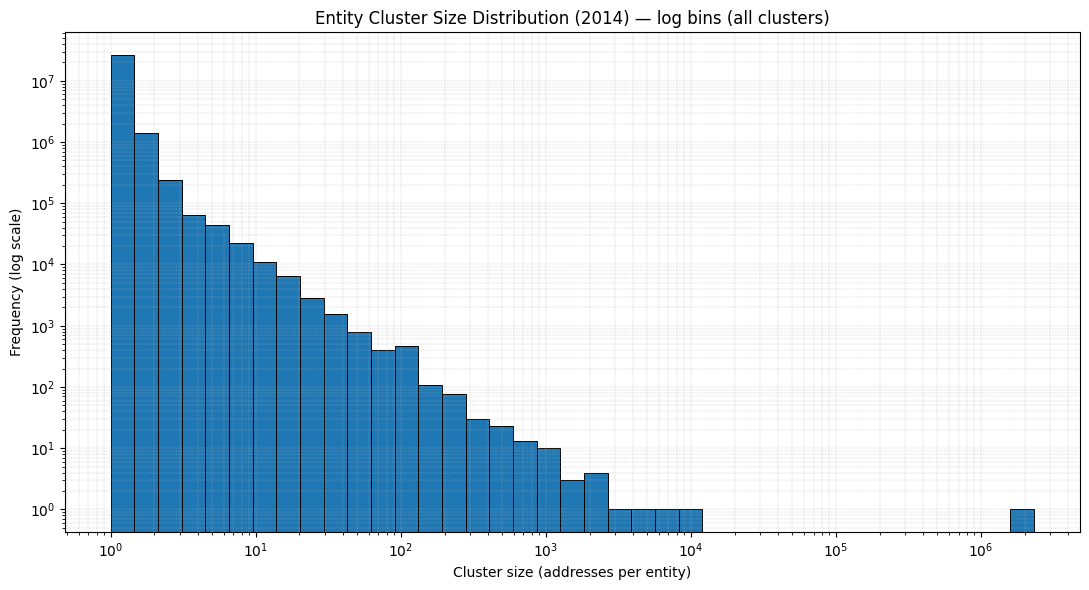

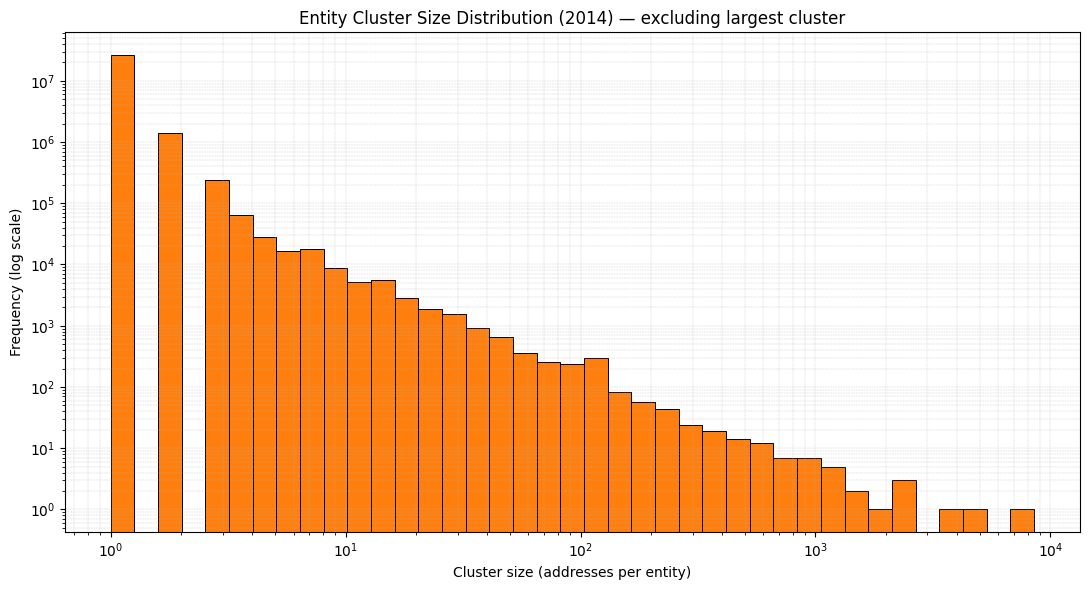

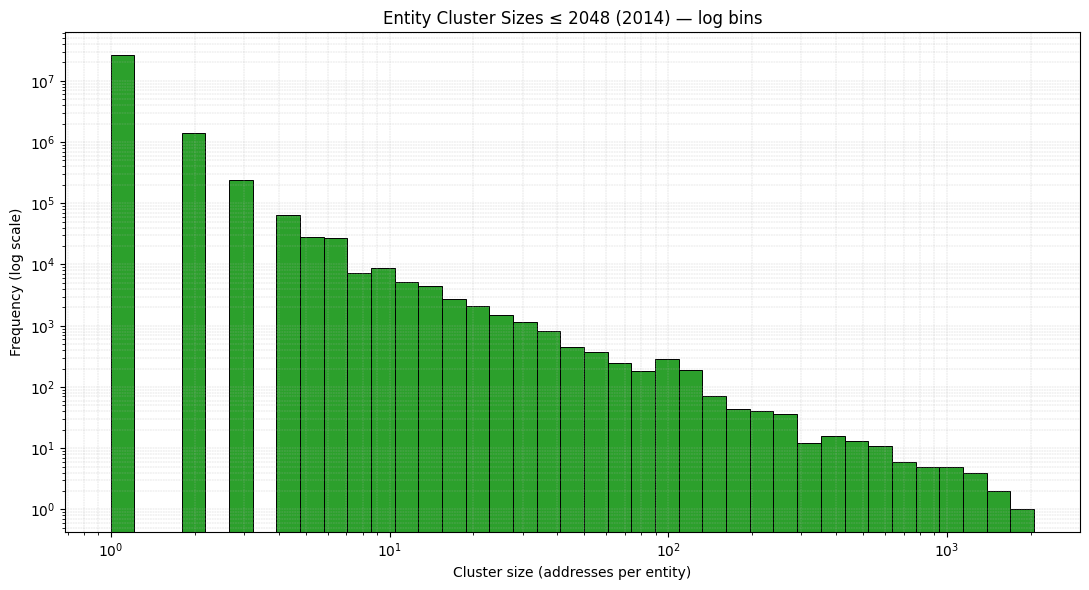

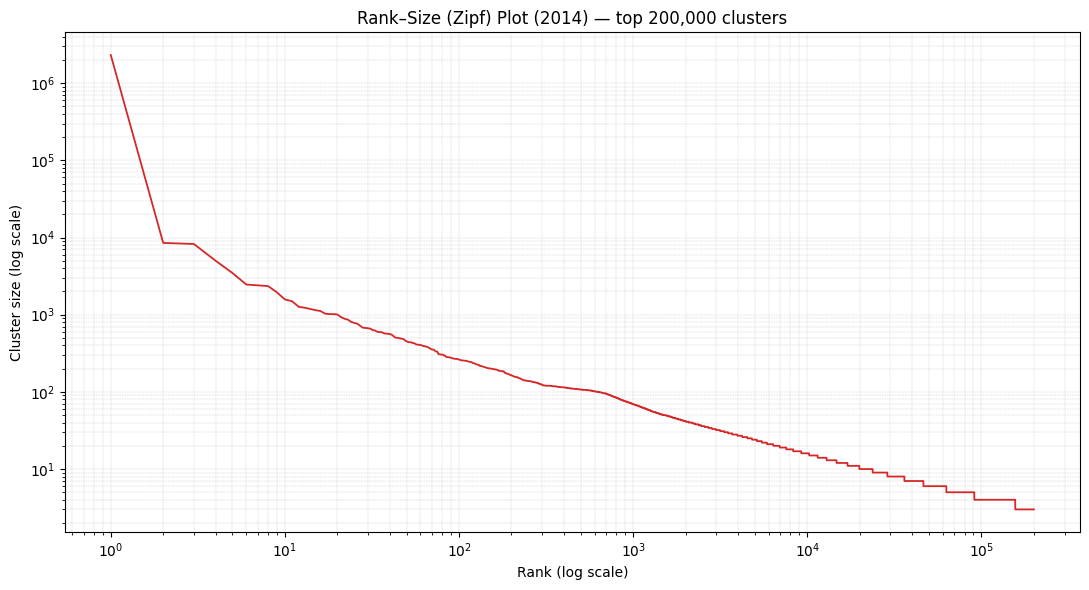

[INFO] Done.


In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from __future__ import annotations

import gc
import glob
import math
import os
import random
import sqlite3
import sys
from collections import Counter
from dataclasses import dataclass
from datetime import date, timedelta
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm.auto import tqdm


# =============================================================================
# Determinism helpers
# =============================================================================

def set_determinism(seed: int) -> None:
    """
    Makes the pipeline *more reproducible* across runs.

    Notes:
      - This pipeline is fundamentally deterministic given a deterministic stream order.
      - The main nondeterminism you observed comes from:
          * SQLite group_concat(DISTINCT ...) ordering (fixed by sorting lists post-transport)
          * Polars unique() order (fixed by sorting before insertion)
      - We still set seeds and env to reduce incidental variation.
    """
    os.environ.setdefault("PYTHONHASHSEED", str(seed))
    random.seed(seed)
    np.random.seed(seed)


# =============================================================================
# Config objects (NO DEFAULTS — everything must be explicit)
# =============================================================================

ValueUnitMode = Literal["infer", "btc", "sats"]
MultiInputPolicy = Literal["one_output", "one_or_two_nonmix"]


@dataclass(frozen=True)
class PathsConfig:
    parquet_io_glob: str
    outputs_dir: Path
    outpoint_db_path: Path
    entity_map_out_path: Path


@dataclass(frozen=True)
class AnalysisConfig:
    analysis_start: date
    analysis_end_exclusive: date
    outpoint_db_lookback_days: int
    value_unit_mode: ValueUnitMode


@dataclass(frozen=True)
class OutputConfig:
    reset_outpoint_db: bool
    write_entity_mapping: bool
    entity_map_compression: str
    entity_write_batch: int
    top_k_clusters_print: int


@dataclass(frozen=True)
class PlotConfig:
    enable_plots: bool
    zipf_top_k: int
    focus_max_size: int
    log_bins: int


@dataclass(frozen=True)
class PerfConfig:
    outpoint_commit_every_rows: int
    prevout_hybrid_threshold: int
    prevout_lookup_chunk: int
    iter_buffer_in: int
    iter_buffer_out: int
    iter_buffer_grouped: int
    gc_every_n_files: int
    tqdm_mininterval: float
    tqdm_miniters: int
    tqdm_postfix_every: int

    # Patch 3: set-based prevout join path (SQLite join + SQLite aggregates + Polars transport)
    use_sql_prevout_join: bool
    vinbuf_insert_chunk: int
    vinbuf_fetch_chunk: int


@dataclass(frozen=True)
class SanityConfig:
    run_sanity_checks: bool
    run_prevout_db_sanity: bool
    prevout_sanity_sample_limit: int
    prevout_sanity_parquet: str | None


@dataclass(frozen=True)
class HeuristicToggles:
    enable_coinjoin_filter: bool
    enable_multi_input: bool
    enable_change: bool
    enable_merge_guards: bool
    precreate_nodes_for_all_output_addrs: bool
    create_nodes_for_all_resolved_inputs: bool


@dataclass(frozen=True)
class HeuristicParams:
    dust_sats: int
    max_fee_abs_sats: int
    max_fee_frac: float
    max_change_inputs_utxos: int
    max_change_spendable_outs: int
    change_require_2_outputs: bool
    multi_input_policy: MultiInputPolicy
    enable_optimal_change_constraint: bool
    optimal_change_slack_sats: int


UltraVoteRule = tuple[int, int]  # (threshold, votes_required)


@dataclass(frozen=True)
class MergeGuardParams:
    # Patch A: Safety ceiling (raised; still recommended as a fuse)
    max_merged_component_size: int

    # Ratio guard (CHANGE only) + ignore tiny components (singleton change)
    merge_ratio_guard: bool
    merge_ratio_max: float
    merge_ratio_big_cluster_min: int
    merge_ratio_small_floor: int

    # Big–big gating (CHANGE only): require multiple "confirmations" per component-pair
    # (Patch A: strengthened tiers above 250k/500k/1M via ultra_change_vote_rules)
    enable_change_merge_votes: bool
    change_vote_min_side: int
    change_vote_merged_trigger: int
    change_votes_required: int
    ultra_change_vote_rules: tuple[UltraVoteRule, ...]

    # Patch B: alternative confirmation signal when pair repetition is rare
    # "change component attempts to attach to too many distinct large anchors"
    enable_change_degree_guard: bool
    change_degree_large_min: int
    change_degree_small_min: int
    change_degree_max_distinct_large: int
    change_degree_set_cap: int

    # Diagnostics: ratio-guard sample log
    ratio_guard_sample_n: int
    ratio_guard_sample_path: Path

    # Patch B: constraint event log (vote pending + degree guard)
    constraint_log_n: int
    constraint_log_path: Path

    # Debug logging of large merges (optional)
    debug_large_change_merges: bool
    debug_change_merge_min: int
    debug_change_merge_log_path: Path


@dataclass(frozen=True)
class ConfidenceConfig:
    """
    Proxy "probability" that an address is *meaningfully clustered* (diagnostic / downstream weight).
    This does NOT claim statistical calibration; it's an evidence-based score in [0,1].
    """
    enable_confidence_proxy: bool
    confidence_out_path: Path
    confidence_compression: str
    confidence_write_batch: int

    # scoring knobs
    size_norm: int
    size_bonus_max: float
    p_singleton: float
    p_base_0: float
    p_base_1: float
    p_base_2plus: float

    include_cluster_size: bool
    include_evidence_bits: bool


# =============================================================================
# Utility helpers
# =============================================================================

def extract_day_from_path(path: str) -> date | None:
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


def addr_type(addr: str) -> str:
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def infer_value_unit_from_sample(sample_vals: list[float]) -> str:
    if not sample_vals:
        return "btc"
    mx = max(sample_vals)
    return "sats" if mx >= 1e6 else "btc"


class UnionFind:
    """
    Union-Find with rank, path compression, component sizes,
    plus Patch B metadata: per-root set of distinct "large anchors" that a CHANGE component tried to attach to.
    """
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []
        self.size: list[int] = []

        # Patch B: root -> set(anchor_root) (only meaningful for "change side" components)
        self.change_large_anchor_roots: dict[int, set[int]] = {}

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        self.size.append(1)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union_roots(self, rx: int, ry: int, *, change_degree_set_cap: int) -> int:
        """
        Union roots (rx, ry) and return new root.
        Merges Patch B sets deterministically, capping to change_degree_set_cap.
        """
        if rx == ry:
            return rx

        parent = self.parent
        rank = self.rank
        size = self.size

        # union by rank; deterministic tie-break already given by call order in your stream
        if rank[rx] < rank[ry]:
            parent[rx] = ry
            size[ry] += size[rx]
            new_root, old_root = ry, rx
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
            size[rx] += size[ry]
            new_root, old_root = rx, ry
        else:
            parent[ry] = rx
            rank[rx] += 1
            size[rx] += size[ry]
            new_root, old_root = rx, ry

        # Patch B: merge anchor-root sets
        sa = self.change_large_anchor_roots.get(new_root)
        sb = self.change_large_anchor_roots.get(old_root)

        if sa is None and sb is None:
            return new_root

        merged: set[int] = set()
        if sa:
            merged |= sa
        if sb:
            merged |= sb

        if len(merged) > change_degree_set_cap:
            merged = set(sorted(merged)[:change_degree_set_cap])

        self.change_large_anchor_roots[new_root] = merged
        self.change_large_anchor_roots.pop(old_root, None)
        return new_root


def _count_dupe_values(values: list[int], dust_sats: int) -> tuple[int, int]:
    vals = [v for v in values if v >= dust_sats]
    if not vals:
        return 0, 0
    cnt = Counter(vals)
    return max(cnt.values()), len(cnt)


def detect_mixing_like(n_in_utxos: int, spendable_outs: list[tuple[str, int]], dust_sats: int) -> bool:
    # Conservative "mixing-like" flags: equal-amount patterns and symmetry.
    n_out = len(spendable_outs)
    if n_in_utxos < 3 or n_out < 3:
        return False

    out_vals = [v for (_a, v) in spendable_outs]
    out_types = [addr_type(a) for (a, _v) in spendable_outs if a is not None]
    unique_vals = len(set(out_vals))
    unique_types = len(set(out_types)) if out_types else 0
    max_dupe, distinct_vals_non_dust = _count_dupe_values(out_vals, dust_sats)

    if max_dupe >= 2 and distinct_vals_non_dust >= 2:
        return True
    if abs(n_in_utxos - n_out) <= 1 and min(n_in_utxos, n_out) >= 3:
        return True
    if n_out >= 4 and unique_vals <= (n_out // 2):
        return True
    if n_out >= 4 and unique_types == 1 and max_dupe >= 2:
        return True
    return False


def multi_input_is_safe(policy: MultiInputPolicy, n_in_utxos: int, n_spendable_out: int, is_mixing_like: bool) -> bool:
    if n_in_utxos < 2:
        return False
    if policy == "one_output":
        return n_spendable_out == 1
    if policy == "one_or_two_nonmix":
        if n_spendable_out == 1:
            return True
        if n_spendable_out == 2 and not is_mixing_like:
            return True
        return False
    raise ValueError(f"Unknown multi_input_policy={policy}")


# =============================================================================
# SQLite outpoint DB + TEMP join buffers
# =============================================================================

def open_outpoint_db(db_path: Path, reset: bool) -> sqlite3.Connection:
    if reset and db_path.exists():
        db_path.unlink()

    conn = sqlite3.connect(str(db_path))
    cur = conn.cursor()

    cur.execute("PRAGMA journal_mode=WAL;")
    cur.execute("PRAGMA synchronous=OFF;")
    cur.execute("PRAGMA temp_store=MEMORY;")
    cur.execute("PRAGMA cache_size=-2000000;")   # ~2GB cache (negative => KB)
    cur.execute("PRAGMA wal_autocheckpoint=5000;")

    conn.isolation_level = None
    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS outpoints (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL,
            address TEXT NOT NULL,
            value_sats INTEGER NOT NULL,
            PRIMARY KEY(txid, n)
        ) WITHOUT ROWID;
        """
    )
    return conn


def init_lookup_tables(conn: sqlite3.Connection) -> None:
    cur = conn.cursor()

    cur.execute("DROP TABLE IF EXISTS keybuf;")
    cur.execute(
        """
        CREATE TEMP TABLE keybuf (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL
        );
        """
    )

    cur.execute("DROP TABLE IF EXISTS vinbuf;")
    cur.execute(
        """
        CREATE TEMP TABLE vinbuf (
            spend_txid TEXT NOT NULL,
            prev_txid  TEXT NOT NULL,
            prev_n     INTEGER NOT NULL
        );
        """
    )


def reset_vinbuf(conn: sqlite3.Connection) -> None:
    conn.execute("DELETE FROM vinbuf;")


def insert_outpoints_no_commit(conn: sqlite3.Connection, rows: list[tuple[str, int, str, int]]) -> None:
    if rows:
        conn.executemany(
            "INSERT OR IGNORE INTO outpoints(txid, n, address, value_sats) VALUES (?, ?, ?, ?);",
            rows,
        )


# Legacy hybrid lookup kept for sanity check helper
def lookup_outpoints_or(conn: sqlite3.Connection, keys: list[tuple[str, int]], chunk_size: int) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))
    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]
        where = " OR ".join(["(txid=? AND n=?)"] * len(chunk))
        params = [p for k in chunk for p in k]
        cur.execute(f"SELECT txid, n, address, value_sats FROM outpoints WHERE {where};", params)
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))
    return out


def lookup_outpoints_join(conn: sqlite3.Connection, keys: list[tuple[str, int]], chunk_size: int) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    keys = list(dict.fromkeys(keys))
    cur = conn.cursor()
    out: dict[tuple[str, int], tuple[str, int]] = {}

    for i in range(0, len(keys), chunk_size):
        chunk = keys[i : i + chunk_size]
        cur.execute("DELETE FROM keybuf;")
        cur.executemany("INSERT INTO keybuf(txid, n) VALUES (?, ?);", chunk)
        cur.execute(
            """
            SELECT k.txid, k.n, o.address, o.value_sats
            FROM keybuf k
            JOIN outpoints o
              ON o.txid = k.txid AND o.n = k.n;
            """
        )
        for txid, n, address, value_sats in cur.fetchall():
            out[(txid, int(n))] = (address, int(value_sats))
    return out


def lookup_outpoints_hybrid(conn: sqlite3.Connection, keys: list[tuple[str, int]], hybrid_threshold: int, join_chunk: int) -> dict[tuple[str, int], tuple[str, int]]:
    if not keys:
        return {}
    if len(keys) < hybrid_threshold:
        return lookup_outpoints_or(conn, keys, chunk_size=500)
    return lookup_outpoints_join(conn, keys, chunk_size=join_chunk)


# =============================================================================
# Patch 3: Resolve + aggregate inputs inside SQLite, transport to Polars
# =============================================================================

def fetch_prevouts_aggs_polars(conn: sqlite3.Connection, fetch_chunk: int) -> pl.DataFrame:
    """
    Returns one row per spend_txid:

      txid: str
      resolved_cnt: int
      sum_inputs_sats: int
      min_input_sats: int
      in_addrs: list[str]   (DISTINCT addresses among resolved inputs for that tx)

    Note: group_concat() uses commas; Bitcoin addresses do not contain commas.
    """
    cur = conn.cursor()
    cur.execute(
        """
        SELECT
            v.spend_txid                                 AS txid,
            COUNT(*)                                      AS resolved_cnt,
            SUM(o.value_sats)                             AS sum_inputs_sats,
            MIN(o.value_sats)                             AS min_input_sats,
            group_concat(DISTINCT o.address)              AS in_addrs_csv
        FROM vinbuf v
        JOIN outpoints o
          ON o.txid = v.prev_txid AND o.n = v.prev_n
        GROUP BY v.spend_txid;
        """
    )

    dfs: list[pl.DataFrame] = []
    while True:
        rows = cur.fetchmany(fetch_chunk)
        if not rows:
            break
        dfs.append(
            pl.DataFrame(
                rows,
                schema=["txid", "resolved_cnt", "sum_inputs_sats", "min_input_sats", "in_addrs_csv"],
                orient="row",
            )
        )

    if not dfs:
        return pl.DataFrame(
            schema={
                "txid": pl.Utf8,
                "resolved_cnt": pl.Int64,
                "sum_inputs_sats": pl.Int64,
                "min_input_sats": pl.Int64,
                "in_addrs": pl.List(pl.Utf8),
            }
        )

    df = pl.concat(dfs, how="vertical", rechunk=True)

    df = df.with_columns(
        pl.col("in_addrs_csv")
        .fill_null("")
        .str.split(",")
        .alias("in_addrs")
    ).drop("in_addrs_csv")

    # Edge-case: NULL -> "" -> [""] should become []
    df = df.with_columns(
        pl.when(pl.col("in_addrs") == [""])
        .then(pl.lit([], dtype=pl.List(pl.Utf8)))
        .otherwise(pl.col("in_addrs"))
        .alias("in_addrs")
    )

    # Determinism: sort the per-tx list of input addresses
    df = df.with_columns(pl.col("in_addrs").list.sort().alias("in_addrs"))

    return df


# =============================================================================
# Sanity checks
# =============================================================================

def run_sanity_checks(
    n_nodes: int,
    node_to_entity: np.ndarray,
    prevout_lookups: int,
    prevout_hits: int,
    top_k: int,
) -> None:
    cluster_size_counter = Counter(list(node_to_entity))
    sizes = list(cluster_size_counter.values())
    if not sizes:
        print("[SANITY] No clusters found.", flush=True)
        return
    sizes_sorted = sorted(sizes, reverse=True)
    total = sum(sizes_sorted)
    largest = sizes_sorted[0]
    frac = largest / total if total else float("nan")

    print("\n[SANITY] Cluster summary", flush=True)
    print(f"  UF nodes (n_nodes): {n_nodes:,}", flush=True)
    print(f"  Total nodes from cluster sizes: {total:,}", flush=True)
    print(f"  Entities (clusters): {len(cluster_size_counter):,}", flush=True)
    print(f"  Largest cluster size: {largest:,}", flush=True)
    print(f"  Largest cluster fraction of nodes: {frac:.2%}", flush=True)
    print(f"\n[SANITY] Top {top_k} cluster sizes:", flush=True)
    print(" ", sizes_sorted[:top_k], flush=True)

    s_asc = sorted(sizes_sorted)
    med = int(s_asc[len(s_asc) // 2])
    p90 = int(s_asc[max(0, math.ceil(0.90 * len(s_asc)) - 1)])
    p99 = int(s_asc[max(0, math.ceil(0.99 * len(s_asc)) - 1)])
    print("\n[SANITY] Quick distribution stats", flush=True)
    print(f"  Median cluster size: {med:,}", flush=True)
    print(f"  90th percentile cluster size: {p90:,}", flush=True)
    print(f"  99th percentile cluster size: {p99:,}", flush=True)

    rate = (prevout_hits / prevout_lookups) if prevout_lookups else float("nan")
    print("\n[SANITY] Prevout lookup hit-rate (DB)", flush=True)
    print(f"  Lookups:  {prevout_lookups:,}", flush=True)
    print(f"  Hits:     {prevout_hits:,}", flush=True)
    print(f"  Hit-rate: {rate:.2%}", flush=True)


def prevout_join_sanity_db(conn: sqlite3.Connection, parquet_path: str, sample_limit: int, hybrid_threshold: int, join_chunk: int) -> None:
    df = pl.read_parquet(parquet_path, columns=["dir", "txid", "prev_txid", "prev_vout"])
    df = df.with_columns(pl.col("dir").cast(pl.Utf8, strict=False).str.to_lowercase().alias("dir"))
    vin = (
        df.filter(pl.col("dir") == "in")
        .select([pl.col("txid").alias("spend_txid"), "prev_txid", "prev_vout"])
        .filter(pl.col("prev_txid").is_not_null() & pl.col("prev_vout").is_not_null())
        .head(sample_limit)
    )
    print("\n[PREVOUT-SANITY | DB]", flush=True)
    print("File:", parquet_path, flush=True)
    print("Vin sample rows:", vin.height, flush=True)
    if vin.height == 0:
        return

    vin2 = vin.with_columns(pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_vout_i64")).filter(
        pl.col("prev_vout_i64").is_not_null()
    )

    keys = [(tx, int(n)) for tx, n in vin2.select(["prev_txid", "prev_vout_i64"]).iter_rows(named=False, buffer_size=200_000)]
    hits = lookup_outpoints_hybrid(conn, keys, hybrid_threshold=hybrid_threshold, join_chunk=join_chunk)
    print(f"DB prevout hit-rate (sample): {len(hits)}/{len(keys)} = {len(hits)/len(keys):.2%}" if keys else "No keys", flush=True)


# =============================================================================
# Plot helpers
# =============================================================================

def _log_bins(max_val: int, bins: int) -> np.ndarray:
    max_val = max(1, int(max_val))
    return np.logspace(0, math.log10(max_val), num=bins)


def plot_hist_logbins(sizes: np.ndarray, title: str, color: str, bins: int, max_x: int | None) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}", flush=True)
        return
    if max_x is None:
        max_x = int(sizes.max())
    b = _log_bins(max_x, bins)
    plt.figure(figsize=(11, 6))
    plt.hist(sizes, bins=b, log=True, color=color, edgecolor="black", linewidth=0.7)
    plt.xscale("log")
    plt.xlabel("Cluster size (addresses per entity)")
    plt.ylabel("Frequency (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


def plot_zipf(sizes: np.ndarray, title: str, color: str, top_k: int) -> None:
    if sizes.size == 0:
        print(f"[PLOT] Skipping empty plot: {title}", flush=True)
        return
    top_k = min(top_k, sizes.size)
    top = np.partition(sizes, -top_k)[-top_k:]
    top_sorted = np.sort(top)[::-1]
    ranks = np.arange(1, top_sorted.size + 1)

    plt.figure(figsize=(11, 6))
    plt.plot(ranks, top_sorted, color=color, linewidth=1.3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Rank (log scale)")
    plt.ylabel("Cluster size (log scale)")
    plt.title(title)
    plt.grid(True, which="both", linestyle="--", linewidth=0.35, alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()


# =============================================================================
# Main executor (explicit-parameter entrypoint)
# =============================================================================

def run_entity_clustering(
    paths: PathsConfig,
    analysis: AnalysisConfig,
    outputs: OutputConfig,
    plots: PlotConfig,
    perf: PerfConfig,
    sanity: SanityConfig,
    toggles: HeuristicToggles,
    params: HeuristicParams,
    guards: MergeGuardParams,
    confidence: ConfidenceConfig,
    *,
    determinism_seed: int,
) -> None:
    """
    Address clustering with:
      - H1 multi-input heuristic under a configurable safety policy
      - Change heuristic (2-output default)
      - Mixing-like filter
      - Merge guards:
          * absolute max component size (all unions)
          * ratio guard ONLY for CHANGE unions (+ small-floor to avoid freezing on singletons)
          * big–big vote-gating with ultra-large strengthening (Patch A)
          * change-degree guard (Patch B) for bridge-y change components
      - Patch 3:
          * prevout resolution via set-based SQLite JOIN (vinbuf → outpoints)
          * per-tx input aggregates computed in SQLite, transported to Polars
      - Node universe:
          * create UF nodes for all resolved input addresses (toggle)
      - Diagnostics:
          * skip reason counters
          * ratio-guard sample log
          * constraint event log (vote pending + degree guard) + uniqueness/repeat diagnostics (Patch B)
      - Confidence proxy output (optional)
    """
    set_determinism(determinism_seed)

    try:
        sys.stdout.reconfigure(line_buffering=True)
        sys.stderr.reconfigure(line_buffering=True)
    except Exception:
        pass

    pl.Config.set_tbl_rows(20)
    pl.Config.set_fmt_str_lengths(80)

    paths.outputs_dir.mkdir(parents=True, exist_ok=True)

    io_paths = sorted(glob.glob(paths.parquet_io_glob))
    print("Parquet file counts:", {"io": len(io_paths)}, flush=True)
    print(f"[INFO] Analysis window: {analysis.analysis_start} .. {analysis.analysis_end_exclusive} (exclusive)", flush=True)

    index_start = analysis.analysis_start - timedelta(days=analysis.outpoint_db_lookback_days)
    print(f"[INFO] Outpoint DB preload start: {index_start} .. {analysis.analysis_end_exclusive} (exclusive)", flush=True)
    print(f"[INFO] Outpoint DB path: {paths.outpoint_db_path} (reset={outputs.reset_outpoint_db})", flush=True)

    eligible: list[tuple[str, date]] = []
    for path in io_paths:
        d = extract_day_from_path(path)
        if d is None:
            continue
        if index_start <= d < analysis.analysis_end_exclusive:
            eligible.append((path, d))

    n_preload_total = sum(1 for _p, d in eligible if d < analysis.analysis_start)
    n_analysis_total = len(eligible) - n_preload_total
    print(f"[INFO] Eligible files in window: {len(eligible)}  (preload={n_preload_total}, analysis={n_analysis_total})", flush=True)

    if not eligible:
        print("[WARN] No eligible parquet files found for the requested window.", flush=True)
        return

    # Pick sanity parquet
    sanity_parquet = sanity.prevout_sanity_parquet
    if sanity_parquet is None:
        for p, d in eligible:
            if analysis.analysis_start <= d < analysis.analysis_end_exclusive:
                sanity_parquet = p
                break
        if sanity_parquet is None and eligible:
            sanity_parquet = eligible[0][0]
    if sanity.run_sanity_checks and sanity_parquet:
        print(f"[INFO] Sanity parquet selected: {sanity_parquet}", flush=True)

    conn = open_outpoint_db(paths.outpoint_db_path, reset=outputs.reset_outpoint_db)
    init_lookup_tables(conn)

    conn.execute("BEGIN;")
    pending_outpoint_rows = 0

    uf = UnionFind()
    addr_to_id: dict[str, int] = {}

    # Flags (diagnostic)
    # bit 1: multi-input evidence
    # bit 2: change-output evidence
    # bit 4: change-anchor evidence
    multi_change_flags = bytearray()
    seen_output_flags = bytearray()

    seen_output_addrs: set[str] | None
    if toggles.precreate_nodes_for_all_output_addrs:
        seen_output_addrs = None
    else:
        seen_output_addrs = set()

    def ensure_flag_capacity(idx: int) -> None:
        needed = idx + 1
        cur = len(seen_output_flags)
        if cur < needed:
            delta = needed - cur
            seen_output_flags.extend(b"\x00" * delta)
            multi_change_flags.extend(b"\x00" * delta)

    def get_addr_id(addr: str) -> int:
        idx = addr_to_id.get(addr)
        if idx is None:
            idx = uf.make_set()
            addr_to_id[addr] = idx
            ensure_flag_capacity(idx)
        return idx

    # value unit mode
    if analysis.value_unit_mode == "btc":
        value_unit: str | None = "btc"
    elif analysis.value_unit_mode == "sats":
        value_unit = "sats"
    elif analysis.value_unit_mode == "infer":
        value_unit = None
    else:
        raise ValueError(f"Unknown value_unit_mode={analysis.value_unit_mode}")

    def value_expr_to_sats() -> pl.Expr:
        nonlocal value_unit
        if value_unit is None:
            return (pl.col("value").cast(pl.Float64, strict=False) * 100_000_000).round(0).cast(pl.Int64, strict=False)
        if value_unit == "sats":
            return pl.col("value").cast(pl.Float64, strict=False).round(0).cast(pl.Int64, strict=False)
        return (pl.col("value").cast(pl.Float64, strict=False) * 100_000_000).round(0).cast(pl.Int64, strict=False)

    stats = {
        "n_files_indexed": 0,
        "n_files_analyzed": 0,
        "n_txs_total": 0,
        "n_txs_coinjoin_flagged": 0,
        "n_txs_with_multiinput": 0,
        "n_txs_with_change_detected": 0,
        "n_prevout_lookups": 0,
        "n_prevout_hits": 0,

        "union_attempts": 0,
        "unions_applied": 0,
        "unions_applied_h1": 0,
        "unions_applied_change": 0,

        "skip_same_component": 0,
        "skip_same_component_h1": 0,
        "skip_same_component_change": 0,

        "unions_skipped": 0,
        "unions_skipped_h1": 0,
        "unions_skipped_change": 0,

        "skip_abs_cap": 0,
        "skip_abs_cap_h1": 0,
        "skip_abs_cap_change": 0,

        "skip_ratio_guard": 0,
        "skip_ratio_guard_change": 0,

        # vote-gating
        "skip_constraint": 0,
        "skip_constraint_change": 0,

        # Patch B: degree-guard
        "skip_degree_guard": 0,
        "skip_degree_guard_change": 0,

        "skip_vote_pending": 0,
        "skip_vote_failed": 0,
    }

    # vote-gating store (unordered (root_a, root_b))
    change_merge_votes: dict[tuple[int, int], int] = {}

    # Patch B: constraint diagnostics
    constraints_added = 0
    constraint_gate_evals_total = 0
    constraint_pair_counts: dict[tuple[int, int], int] = {}
    constraint_unique_pairs: set[tuple[int, int]] = set()
    constraint_pairs_repeated = 0

    # ratio-guard sample log state
    ratio_guard_samples_written = 0
    ratio_guard_sample_fh = None
    try:
        if guards.ratio_guard_sample_n > 0:
            ratio_guard_sample_fh = open(guards.ratio_guard_sample_path, "w", encoding="utf-8")
            ratio_guard_sample_fh.write(
                "txid\tsa\tsb\ts_big\ts_small\tratio\tchange_side\tbig_side\tbig_is_change\tchange_comp_size\tinput_comp_size\n"
            )
    except Exception:
        ratio_guard_sample_fh = None

    # constraint log state (Patch B)
    constraint_log_written = 0
    constraint_log_fh = None
    try:
        if guards.constraint_log_n > 0:
            constraint_log_fh = open(guards.constraint_log_path, "w", encoding="utf-8")
            constraint_log_fh.write(
                "txid\tevent\treason\tsa\tsb\tmerged\tmin_side\tbig_side\tratio\t"
                "votes\tvotes_required\tkey_r0\tkey_r1\ttriggered_by\tbig_is_change\t"
                "pair_seen\tis_repeat\tchange_root\tanchor_root\tchange_distinct_large\n"
            )
    except Exception:
        constraint_log_fh = None

    def _votes_required_for_sizes(min_side: int, big_side: int, merged: int) -> int:
        # base requirement
        req = guards.change_votes_required
        # Patch A: ultra tiers (take maximum requirement among triggered thresholds)
        for thr, req_thr in guards.ultra_change_vote_rules:
            if big_side >= thr or merged >= thr:
                if req_thr > req:
                    req = req_thr
        return req

    def _log_constraint_event(
        *,
        txid: str | None,
        event: str,  # "VOTE_PENDING" | "DEGREE_GUARD"
        reason: str,  # "CHANGE" or "H1" (here: only CHANGE)
        sa: int,
        sb: int,
        merged: int,
        min_side: int,
        big_side: int,
        ratio: float,
        votes: int,
        votes_required: int,
        key_r0: int,
        key_r1: int,
        triggered_by: str,
        big_is_change: int,
        pair_seen: int,
        is_repeat: int,
        change_root: int,
        anchor_root: int,
        change_distinct_large: int,
    ) -> None:
        nonlocal constraint_log_written
        if (
            constraint_log_fh is None
            or constraint_log_written >= guards.constraint_log_n
            or txid is None
        ):
            return
        constraint_log_fh.write(
            f"{txid}\t{event}\t{reason}\t{sa}\t{sb}\t{merged}\t{min_side}\t{big_side}\t{ratio}\t"
            f"{votes}\t{votes_required}\t{key_r0}\t{key_r1}\t{triggered_by}\t{big_is_change}\t"
            f"{pair_seen}\t{is_repeat}\t{change_root}\t{anchor_root}\t{change_distinct_large}\n"
        )
        constraint_log_written += 1

    def union_guarded(a: int, b: int, reason: Literal["H1", "CHANGE"], txid: str | None) -> bool:
        nonlocal ratio_guard_samples_written, constraint_log_written
        nonlocal constraints_added, constraint_gate_evals_total, constraint_pairs_repeated

        stats["union_attempts"] += 1
        ra = uf.find(a)
        rb = uf.find(b)
        if ra == rb:
            stats["skip_same_component"] += 1
            if reason == "H1":
                stats["skip_same_component_h1"] += 1
            else:
                stats["skip_same_component_change"] += 1
            return False

        sa = uf.size[ra]
        sb = uf.size[rb]
        merged = sa + sb

        # No guards path
        if not toggles.enable_merge_guards:
            uf.union_roots(ra, rb, change_degree_set_cap=guards.change_degree_set_cap)
            stats["unions_applied"] += 1
            if reason == "H1":
                stats["unions_applied_h1"] += 1
            else:
                stats["unions_applied_change"] += 1
            return True

        # Absolute cap (all unions)
        if merged > guards.max_merged_component_size:
            stats["unions_skipped"] += 1
            if reason == "H1":
                stats["unions_skipped_h1"] += 1
                stats["skip_abs_cap_h1"] += 1
            else:
                stats["unions_skipped_change"] += 1
                stats["skip_abs_cap_change"] += 1
            stats["skip_abs_cap"] += 1
            return False

        # Ratio guard ONLY for CHANGE (with small-floor)
        if guards.merge_ratio_guard and reason == "CHANGE":
            s_big = sa if sa >= sb else sb
            s_small = sb if sa >= sb else sa

            if s_small >= guards.merge_ratio_small_floor and s_big >= guards.merge_ratio_big_cluster_min:
                ratio = (s_big / s_small) if s_small > 0 else float("inf")
                if ratio > guards.merge_ratio_max:
                    stats["unions_skipped"] += 1
                    stats["unions_skipped_change"] += 1
                    stats["skip_ratio_guard"] += 1
                    stats["skip_ratio_guard_change"] += 1

                    # Sample log (assumes CHANGE call is (anchor=a, change=b))
                    if (
                        ratio_guard_sample_fh is not None
                        and ratio_guard_samples_written < guards.ratio_guard_sample_n
                        and txid is not None
                    ):
                        big_root = ra if sa >= sb else rb
                        big_is_change = 1 if big_root == rb else 0
                        big_side = "b" if big_is_change else "a"

                        ratio_guard_sample_fh.write(
                            f"{txid}\t{sa}\t{sb}\t{s_big}\t{s_small}\t{ratio}\t"
                            f"b\t{big_side}\t{big_is_change}\t{sb}\t{sa}\n"
                        )
                        ratio_guard_samples_written += 1
                    return False

        # Patch B: change-degree guard (CHANGE-only)
        # If a CHANGE component tries to attach to too many distinct LARGE anchors, block.
        if guards.enable_change_degree_guard and reason == "CHANGE":
            # Convention in pipeline: a=anchor, b=change
            anchor_root = ra
            change_root = rb
            anchor_size = sa
            change_size = sb

            change_distinct_large = 0
            if (anchor_size >= guards.change_degree_large_min) and (change_size >= guards.change_degree_small_min):
                s = uf.change_large_anchor_roots.get(change_root)
                if s is None:
                    s = set()
                    uf.change_large_anchor_roots[change_root] = s
                s.add(anchor_root)
                if len(s) > guards.change_degree_set_cap:
                    # deterministic cap
                    uf.change_large_anchor_roots[change_root] = set(sorted(s)[:guards.change_degree_set_cap])
                    s = uf.change_large_anchor_roots[change_root]
                change_distinct_large = len(s)

                if change_distinct_large > guards.change_degree_max_distinct_large:
                    stats["unions_skipped"] += 1
                    stats["unions_skipped_change"] += 1
                    stats["skip_degree_guard"] += 1
                    stats["skip_degree_guard_change"] += 1

                    # log as a constraint event
                    s_big = max(sa, sb)
                    s_small = min(sa, sb)
                    ratio = (s_big / s_small) if s_small > 0 else float("inf")
                    big_root = ra if sa >= sb else rb
                    big_is_change = 1 if big_root == rb else 0
                    r0, r1 = (anchor_root, change_root) if anchor_root < change_root else (change_root, anchor_root)

                    _log_constraint_event(
                        txid=txid,
                        event="DEGREE_GUARD",
                        reason=reason,
                        sa=sa, sb=sb,
                        merged=merged,
                        min_side=min(sa, sb),
                        big_side=max(sa, sb),
                        ratio=ratio,
                        votes=0,
                        votes_required=0,
                        key_r0=r0,
                        key_r1=r1,
                        triggered_by="degree_guard",
                        big_is_change=big_is_change,
                        pair_seen=0,
                        is_repeat=0,
                        change_root=change_root,
                        anchor_root=anchor_root,
                        change_distinct_large=change_distinct_large,
                    )
                    return False

        # Big–big vote-gating ONLY for CHANGE (Patch A + Patch B logging)
        if guards.enable_change_merge_votes and reason == "CHANGE":
            min_side = sa if sa <= sb else sb
            big_side = sa if sa >= sb else sb

            triggered = False
            triggered_by = "none"

            # NOTE: this is intentionally "big–big": only triggers when BOTH sides are large enough
            if guards.change_vote_min_side > 0 and min_side >= guards.change_vote_min_side:
                triggered = True
                triggered_by = "min_side"
            if (not triggered) and guards.change_vote_merged_trigger > 0 and merged >= guards.change_vote_merged_trigger:
                triggered = True
                triggered_by = "merged"

            if triggered:
                r0, r1 = (ra, rb) if ra < rb else (rb, ra)
                k = (r0, r1)

                # track how often we even see this constrained pair (uniqueness/repeat)
                constraint_gate_evals_total += 1
                prev_seen = constraint_pair_counts.get(k, 0)
                pair_seen = prev_seen + 1
                constraint_pair_counts[k] = pair_seen
                if pair_seen == 1:
                    constraints_added += 1
                    constraint_unique_pairs.add(k)
                elif pair_seen == 2:
                    constraint_pairs_repeated += 1  # count pair as "repeated" once
                is_repeat = 1 if pair_seen > 1 else 0

                prev_votes = change_merge_votes.get(k, 0)
                votes = prev_votes + 1
                change_merge_votes[k] = votes

                votes_required = _votes_required_for_sizes(min_side=min_side, big_side=big_side, merged=merged)

                if votes < votes_required:
                    stats["unions_skipped"] += 1
                    stats["unions_skipped_change"] += 1
                    stats["skip_constraint"] += 1
                    stats["skip_constraint_change"] += 1
                    stats["skip_vote_pending"] += 1

                    s_big = max(sa, sb)
                    s_small = min(sa, sb)
                    ratio = (s_big / s_small) if s_small > 0 else float("inf")
                    big_root = ra if sa >= sb else rb
                    big_is_change = 1 if big_root == rb else 0

                    # Log vote-pending constraint event
                    _log_constraint_event(
                        txid=txid,
                        event="VOTE_PENDING",
                        reason=reason,
                        sa=sa, sb=sb,
                        merged=merged,
                        min_side=min_side,
                        big_side=big_side,
                        ratio=ratio,
                        votes=votes,
                        votes_required=votes_required,
                        key_r0=r0,
                        key_r1=r1,
                        triggered_by=triggered_by,
                        big_is_change=big_is_change,
                        pair_seen=pair_seen,
                        is_repeat=is_repeat,
                        change_root=rb,         # in this pipeline: rb is change side root
                        anchor_root=ra,
                        change_distinct_large=0,
                    )
                    return False

        # Debug log of large CHANGE merges that pass all guards (optional)
        if guards.debug_large_change_merges and reason == "CHANGE" and merged >= guards.debug_change_merge_min and txid is not None:
            try:
                with open(guards.debug_change_merge_log_path, "a", encoding="utf-8") as f:
                    f.write(f"{txid}\t{sa}\t{sb}\t{merged}\n")
            except Exception:
                pass

        # Apply union
        uf.union_roots(ra, rb, change_degree_set_cap=guards.change_degree_set_cap)
        stats["unions_applied"] += 1
        if reason == "H1":
            stats["unions_applied_h1"] += 1
        else:
            stats["unions_applied_change"] += 1
        return True

    # tqdm: force stdout
    pbar = tqdm(
        eligible,
        total=len(eligible),
        unit="file",
        dynamic_ncols=True,
        mininterval=perf.tqdm_mininterval,
        miniters=perf.tqdm_miniters,
        smoothing=0,
        desc="Processing parquet",
        file=sys.stdout,
        leave=True,
    )

    DIR_NEEDS_NORMALIZATION: bool | None = None

    def log(msg: str) -> None:
        tqdm.write(msg, file=sys.stdout)

    def mark_outputs_seen(outputs_list: list[tuple[str | None, int]]) -> None:
        if toggles.precreate_nodes_for_all_output_addrs:
            for a, _v in outputs_list:
                if a is None:
                    continue
                a_id = get_addr_id(a)
                seen_output_flags[a_id] = 1
        else:
            assert seen_output_addrs is not None
            for a, _v in outputs_list:
                if a is not None:
                    seen_output_addrs.add(a)

    for i, (path, file_day) in enumerate(pbar, start=1):
        in_analysis = (analysis.analysis_start <= file_day < analysis.analysis_end_exclusive)

        if (i % perf.tqdm_postfix_every) == 0:
            pbar.set_postfix_str(f"{'analysis' if in_analysis else 'preload'} day={file_day}")

        if in_analysis:
            stats["n_files_analyzed"] += 1
            if stats["n_files_analyzed"] <= 5:
                log(f"[{stats['n_files_analyzed']}] Processing {path} (day={file_day}) ...")
            elif (stats["n_files_analyzed"] % 250) == 0:
                log(f"[{stats['n_files_analyzed']}] Processing ... (day={file_day})")
        else:
            stats["n_files_indexed"] += 1
            if stats["n_files_indexed"] <= 3:
                log(f"[preload {stats['n_files_indexed']}] Indexing outputs only: {path} (day={file_day}) ...")

        df = pl.read_parquet(path, columns=["dir", "txid", "n", "prev_txid", "prev_vout", "address", "value"])

        if DIR_NEEDS_NORMALIZATION is None:
            dir_uniques = df.select(pl.col("dir").cast(pl.Utf8, strict=False).unique()).to_series().to_list()
            DIR_NEEDS_NORMALIZATION = any(
                (d is not None and str(d).lower() in ("in", "out") and str(d) not in ("in", "out")) for d in dir_uniques
            )
            if in_analysis and stats["n_files_analyzed"] == 1:
                log(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

        if DIR_NEEDS_NORMALIZATION:
            df = df.with_columns(pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir"))

        # Infer unit once if needed
        if value_unit is None:
            sample = (
                df.filter(pl.col("dir") == "out")
                .select(pl.col("value").cast(pl.Float64, strict=False))
                .drop_nulls()
                .head(5000)
                .to_series()
                .to_list()
            )
            value_unit = infer_value_unit_from_sample(sample)
            log(f"[INFO] Detected value unit: {value_unit}  (all internal amount logic uses satoshis)")

        # 1) Index outputs into outpoints DB
        out_all = (
            df.filter(pl.col("dir") == "out")
            .filter(pl.col("txid").is_not_null())
            .filter(pl.col("n").is_not_null())
            .select(
                pl.col("txid"),
                pl.col("n").cast(pl.Int64, strict=False).alias("n"),
                pl.col("address"),
                value_expr_to_sats().alias("value_sats"),
            )
        )

        out_for_db = out_all.filter(pl.col("address").is_not_null()).filter(pl.col("value_sats").is_not_null())
        if out_for_db.height > 0:
            rows = [
                (txid, int(n), addr, int(vs))
                for txid, n, addr, vs in out_for_db.select(["txid", "n", "address", "value_sats"]).iter_rows(
                    named=False, buffer_size=perf.iter_buffer_out
                )
            ]
            insert_outpoints_no_commit(conn, rows)
            pending_outpoint_rows += len(rows)

            if pending_outpoint_rows >= perf.outpoint_commit_every_rows:
                conn.execute("COMMIT;")
                conn.execute("BEGIN;")
                pending_outpoint_rows = 0

            if toggles.precreate_nodes_for_all_output_addrs:
                # Determinism: sort unique output addrs before node creation
                out_u = out_for_db.select(pl.col("address").unique()).to_series().to_list()
                for addr in sorted(out_u):
                    _ = get_addr_id(addr)

        if not in_analysis:
            del df, out_all, out_for_db
            if (i % perf.gc_every_n_files) == 0:
                gc.collect()
            continue

        # 2) Build VIN (spend_txid, prev_txid, prev_n)
        in_df = (
            df.filter(pl.col("dir") == "in")
            .filter(pl.col("txid").is_not_null())
            .filter(pl.col("prev_txid").is_not_null())
            .filter(pl.col("prev_vout").is_not_null())
            .select(
                pl.col("txid").alias("spend_txid"),
                pl.col("prev_txid"),
                pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_n"),
            )
            .filter(pl.col("prev_n").is_not_null())
        )

        del df
        if (i % perf.gc_every_n_files) == 0:
            gc.collect()

        if in_df.height == 0:
            del in_df
            del out_all, out_for_db
            if (i % perf.gc_every_n_files) == 0:
                gc.collect()
            continue

        # n_in_utxos per spend tx
        in_counts = (
            in_df.group_by("spend_txid")
            .len()
            .rename({"spend_txid": "txid", "len": "n_in_utxos"})
        )

        # 2a) Resolve prevouts via SQLite join + SQLite aggregates
        if not perf.use_sql_prevout_join:
            raise RuntimeError("perf.use_sql_prevout_join=False is not supported in this build; set it True.")

        reset_vinbuf(conn)

        cur = conn.cursor()
        insert_sql = "INSERT INTO vinbuf(spend_txid, prev_txid, prev_n) VALUES (?, ?, ?);"
        batch: list[tuple[str, str, int]] = []
        total_vin = 0

        for spend_txid, prev_txid, prev_n in in_df.select(["spend_txid", "prev_txid", "prev_n"]).iter_rows(
            named=False, buffer_size=perf.iter_buffer_in
        ):
            batch.append((str(spend_txid), str(prev_txid), int(prev_n)))
            if len(batch) >= perf.vinbuf_insert_chunk:
                cur.executemany(insert_sql, batch)
                total_vin += len(batch)
                batch.clear()

        if batch:
            cur.executemany(insert_sql, batch)
            total_vin += len(batch)
            batch.clear()

        stats["n_prevout_lookups"] += total_vin

        resolved_aggs = fetch_prevouts_aggs_polars(conn, fetch_chunk=perf.vinbuf_fetch_chunk)

        if resolved_aggs.height > 0:
            resolved_inputs_sum = resolved_aggs.select(pl.col("resolved_cnt").sum()).item()
            stats["n_prevout_hits"] += int(resolved_inputs_sum) if resolved_inputs_sum is not None else 0

        del in_df

        # Node universe patch: create nodes for ALL resolved input addresses
        if toggles.create_nodes_for_all_resolved_inputs and resolved_aggs.height > 0:
            u = (
                resolved_aggs
                .select(pl.col("in_addrs").explode().drop_nulls().unique())
                .to_series()
                .to_list()
            )
            for a in sorted(u):
                _ = get_addr_id(a)

        # 3) Outputs grouped per tx
        if out_all.height == 0:
            del out_all, out_for_db, in_counts, resolved_aggs
            if (i % perf.gc_every_n_files) == 0:
                gc.collect()
            continue

        vout_grouped = (
            out_all.group_by("txid")
            .agg(
                pl.col("address").alias("out_addrs_all"),
                pl.col("value_sats").alias("out_values_sats_all"),
            )
        )
        del out_all, out_for_db

        # Join tx-level inputs + resolved stats to outputs
        tx_joined = (
            vout_grouped
            .join(in_counts, on="txid", how="inner")
            .join(resolved_aggs, on="txid", how="left")
        )
        del vout_grouped, in_counts, resolved_aggs

        for (
            txid,
            out_addrs_all,
            out_values_all,
            n_in_utxos,
            resolved_cnt,
            sum_inputs_sats,
            min_input_sats,
            in_addrs,
        ) in tx_joined.select(
            ["txid", "out_addrs_all", "out_values_sats_all", "n_in_utxos", "resolved_cnt", "sum_inputs_sats", "min_input_sats", "in_addrs"]
        ).iter_rows(named=False, buffer_size=perf.iter_buffer_grouped):

            if not out_addrs_all or not out_values_all:
                continue

            n_in_utxos_i = int(n_in_utxos) if n_in_utxos is not None else 0
            if n_in_utxos_i == 0:
                continue

            stats["n_txs_total"] += 1

            outputs_list: list[tuple[str | None, int]] = []
            sum_outputs_sats = 0
            for a, v in zip(out_addrs_all, out_values_all):
                if v is None:
                    continue
                vi = int(v)
                outputs_list.append((a, vi))
                sum_outputs_sats += vi

            spendable = [(a, v) for (a, v) in outputs_list if a is not None and v >= params.dust_sats]
            if not spendable:
                mark_outputs_seen(outputs_list)
                continue

            # Mixing-like filter
            is_mixing_like = False
            if toggles.enable_coinjoin_filter:
                is_mixing_like = detect_mixing_like(n_in_utxos_i, spendable, dust_sats=params.dust_sats)
                if is_mixing_like:
                    stats["n_txs_coinjoin_flagged"] += 1
                    mark_outputs_seen(outputs_list)
                    continue

            if in_addrs is None:
                mark_outputs_seen(outputs_list)
                continue

            in_addrs_list = list(in_addrs)  # already list-sorted in fetch_prevouts_aggs_polars()
            if not in_addrs_list:
                mark_outputs_seen(outputs_list)
                continue

            # H1 multi-input unions
            if toggles.enable_multi_input:
                safe = multi_input_is_safe(params.multi_input_policy, n_in_utxos_i, len(spendable), is_mixing_like)
                if safe:
                    stats["n_txs_with_multiinput"] += 1
                    if len(in_addrs_list) >= 2:
                        in_ids = [get_addr_id(a) for a in in_addrs_list]
                        for idx in in_ids:
                            multi_change_flags[idx] |= 1
                        first_id = in_ids[0]
                        for idx in in_ids[1:]:
                            union_guarded(first_id, idx, reason="H1", txid=str(txid))
                    else:
                        idx = get_addr_id(in_addrs_list[0])
                        multi_change_flags[idx] |= 1

            # CHANGE unions
            if toggles.enable_change:
                n_spendable_out = len(spendable)

                if params.change_require_2_outputs and n_spendable_out != 2:
                    mark_outputs_seen(outputs_list)
                    continue
                if n_in_utxos_i > params.max_change_inputs_utxos:
                    mark_outputs_seen(outputs_list)
                    continue
                if n_spendable_out > params.max_change_spendable_outs:
                    mark_outputs_seen(outputs_list)
                    continue

                resolved_cnt_i = int(resolved_cnt) if resolved_cnt is not None else 0
                if resolved_cnt_i != n_in_utxos_i:
                    mark_outputs_seen(outputs_list)
                    continue

                in_types = [addr_type(a) for a in in_addrs_list]
                if len(set(in_types)) != 1:
                    mark_outputs_seen(outputs_list)
                    continue
                majority_type = in_types[0]

                spendable_addrs = [a for (a, _v) in spendable]
                if len(spendable_addrs) != len(set(spendable_addrs)):
                    mark_outputs_seen(outputs_list)
                    continue

                in_addr_set_fast = set(in_addrs_list)
                candidates: list[tuple[str, int]] = []
                for a, v in spendable:
                    if a in in_addr_set_fast:
                        continue
                    if addr_type(a) != majority_type:
                        continue
                    if toggles.precreate_nodes_for_all_output_addrs:
                        a_id = get_addr_id(a)
                        if seen_output_flags[a_id]:
                            continue
                    else:
                        assert seen_output_addrs is not None
                        if a in seen_output_addrs:
                            continue
                    candidates.append((a, v))

                if len(candidates) != 1:
                    mark_outputs_seen(outputs_list)
                    continue

                change_addr, change_val = candidates[0]

                sum_in_i = int(sum_inputs_sats) if sum_inputs_sats is not None else 0
                fee = sum_in_i - sum_outputs_sats
                if sum_in_i <= 0 or fee < 0:
                    mark_outputs_seen(outputs_list)
                    continue
                if fee > params.max_fee_abs_sats or fee > int(params.max_fee_frac * sum_in_i):
                    mark_outputs_seen(outputs_list)
                    continue

                spend_vals = [v for (_a, v) in spendable]
                if n_spendable_out == 2:
                    other_val = max(v for (_a, v) in spendable if _a != change_addr)
                    if not (change_val < other_val):
                        mark_outputs_seen(outputs_list)
                        continue
                elif n_spendable_out == 3:
                    if change_val != min(spend_vals):
                        mark_outputs_seen(outputs_list)
                        continue
                else:
                    mark_outputs_seen(outputs_list)
                    continue

                if params.enable_optimal_change_constraint:
                    mn = int(min_input_sats) if min_input_sats is not None else None
                    if mn is None:
                        mark_outputs_seen(outputs_list)
                        continue
                    if change_val > (mn - fee + params.optimal_change_slack_sats):
                        mark_outputs_seen(outputs_list)
                        continue

                change_id = get_addr_id(change_addr)
                multi_change_flags[change_id] |= 2

                anchor_id = get_addr_id(in_addrs_list[0])
                multi_change_flags[anchor_id] |= 4

                stats["n_txs_with_change_detected"] += 1
                union_guarded(anchor_id, change_id, reason="CHANGE", txid=str(txid))

            mark_outputs_seen(outputs_list)

        del tx_joined
        if (i % perf.gc_every_n_files) == 0:
            gc.collect()

    pbar.close()
    conn.execute("COMMIT;")

    # Close diagnostic file handles
    try:
        if ratio_guard_sample_fh is not None:
            ratio_guard_sample_fh.close()
            log(f"[DIAG] Wrote ratio-guard sample log: {guards.ratio_guard_sample_path}  (n={ratio_guard_samples_written})")
    except Exception:
        pass
    try:
        if constraint_log_fh is not None:
            constraint_log_fh.close()
            log(f"[DIAG] Wrote constraint-event log: {guards.constraint_log_path}  (n={constraint_log_written})")
    except Exception:
        pass

    # Finalize entity mapping
    print("\nFinalizing entity mapping (compressing components)...", flush=True)
    n_nodes = len(addr_to_id)
    print(f"Number of unique addresses with UF nodes: {n_nodes:,}", flush=True)
    hit_rate = stats["n_prevout_hits"] / max(1, stats["n_prevout_lookups"])
    print(f"[INFO] prevout lookups: {stats['n_prevout_lookups']:,}  hits: {stats['n_prevout_hits']:,}  hit-rate: {hit_rate:.3%}", flush=True)

    if n_nodes == 0:
        print("No union-find nodes created.", flush=True)
        conn.close()
        return

    node_to_entity = np.empty(n_nodes, dtype=np.int32)
    root_to_entity: dict[int, int] = {}
    next_entity_id = 0
    for node in range(n_nodes):
        root = uf.find(node)
        ent = root_to_entity.get(root)
        if ent is None:
            ent = next_entity_id
            root_to_entity[root] = ent
            next_entity_id += 1
        node_to_entity[node] = ent

    n_entities = next_entity_id
    print(f"Number of entities (clusters): {n_entities:,}", flush=True)

    counts = np.bincount(node_to_entity, minlength=n_entities).astype(np.int64)
    cluster_sizes = counts[counts > 0]

    largest = int(cluster_sizes.max()) if cluster_sizes.size else 0
    largest_frac = (largest / n_nodes) if n_nodes else float("nan")

    top_k = min(outputs.top_k_clusters_print, n_entities)
    top_ids = np.argpartition(counts, -top_k)[-top_k:]
    top_ids_sorted = top_ids[np.argsort(counts[top_ids])[::-1]]

    print("\n[TOP CLUSTERS]", flush=True)
    for rank, eid in enumerate(top_ids_sorted, start=1):
        sz = int(counts[eid])
        frac = (sz / n_nodes) if n_nodes else float("nan")
        print(f"  #{rank:02d}  entity_id={int(eid):>8d}  size={sz:>10,d}  frac={frac:>7.2%}", flush=True)

    q50, q90, q99 = np.quantile(cluster_sizes, [0.5, 0.9, 0.99])
    print("\n[CLUSTER STATS]", flush=True)
    print(f"  Entities: {n_entities:,}", flush=True)
    print(f"  Largest cluster size: {largest:,}", flush=True)
    print(f"  Largest cluster fraction of nodes: {largest_frac:.2%}", flush=True)
    print(f"  Median cluster size: {int(q50)}", flush=True)
    print(f"  90th percentile: {int(q90)}", flush=True)
    print(f"  99th percentile: {int(q99)}", flush=True)

    flags_view = multi_change_flags[:n_nodes]
    n_addrs_multi = sum(1 for v in flags_view if (v & 1))
    n_addrs_change_out = sum(1 for v in flags_view if (v & 2))
    n_addrs_change_anchor = sum(1 for v in flags_view if (v & 4))
    n_addrs_touched = sum(1 for v in flags_view if (v & 7))

    print("\n[HEURISTIC COVERAGE (node-level)]", flush=True)
    print(f"  Total txs processed (>=1 input UTXO): {stats['n_txs_total']:,}", flush=True)
    print(f"  Mixing-like skipped: {stats['n_txs_coinjoin_flagged']:,}", flush=True)
    print(f"  Multi-input txs (SAFE policy applied): {stats['n_txs_with_multiinput']:,}", flush=True)
    print(f"  Change detected (tight): {stats['n_txs_with_change_detected']:,}", flush=True)
    print(f"  Nodes marked multi-input: {n_addrs_multi:,}", flush=True)
    print(f"  Nodes marked change-output: {n_addrs_change_out:,}", flush=True)
    print(f"  Nodes marked change-anchor: {n_addrs_change_anchor:,}", flush=True)
    print(f"  Nodes touched by any heuristic: {n_addrs_touched:,}", flush=True)

    print("\n[UNION DIAGNOSTICS]", flush=True)
    print(f"  Union attempts: {stats['union_attempts']:,}", flush=True)
    print(f"  Unions applied: {stats['unions_applied']:,}", flush=True)
    print(f"    - applied via H1:     {stats['unions_applied_h1']:,}", flush=True)
    print(f"    - applied via CHANGE: {stats['unions_applied_change']:,}", flush=True)

    print(f"  skip_same_component (already merged): {stats['skip_same_component']:,}", flush=True)
    print(f"    - same_component via H1:     {stats['skip_same_component_h1']:,}", flush=True)
    print(f"    - same_component via CHANGE: {stats['skip_same_component_change']:,}", flush=True)

    print(f"  Unions skipped by guards/votes/constraints: {stats['unions_skipped']:,}", flush=True)
    print(f"    - skipped (H1):     {stats['unions_skipped_h1']:,}", flush=True)
    print(f"    - skipped (CHANGE): {stats['unions_skipped_change']:,}", flush=True)

    print("  Skip breakdown:", flush=True)
    print(f"    - skip_abs_cap: {stats['skip_abs_cap']:,}  (H1={stats['skip_abs_cap_h1']:,}, CHANGE={stats['skip_abs_cap_change']:,})", flush=True)
    print(f"    - skip_ratio_guard: {stats['skip_ratio_guard']:,}  (CHANGE-only)", flush=True)
    print(f"    - skip_constraint: {stats['skip_constraint']:,}  (CHANGE-only; vote pending)", flush=True)
    print(f"    - skip_degree_guard: {stats['skip_degree_guard']:,}  (CHANGE-only)", flush=True)
    print(f"    - skip_vote_pending: {stats['skip_vote_pending']:,}", flush=True)
    print(f"    - skip_vote_failed:  {stats['skip_vote_failed']:,}", flush=True)

    if guards.enable_change_merge_votes or guards.enable_change_degree_guard:
        print("\n[CONSTRAINT DIAGNOSTICS]", flush=True)
        print(f"  Vote-gating pairs seen (unique): {len(constraint_unique_pairs):,}", flush=True)
        print(f"  Vote-gating evaluations (total): {constraint_gate_evals_total:,}", flush=True)
        print(f"  Vote-gating pairs that repeated: {constraint_pairs_repeated:,}", flush=True)
        active_pairs = sum(1 for _k, v in change_merge_votes.items() if v > 0)
        print(f"  Vote pairs tracked (total): {active_pairs:,}", flush=True)

    # Sanity
    if sanity.run_sanity_checks:
        run_sanity_checks(
            n_nodes=n_nodes,
            node_to_entity=node_to_entity,
            prevout_lookups=stats["n_prevout_lookups"],
            prevout_hits=stats["n_prevout_hits"],
            top_k=20,
        )
        if sanity.run_prevout_db_sanity and sanity_parquet:
            prevout_join_sanity_db(
                conn,
                sanity_parquet,
                sample_limit=sanity.prevout_sanity_sample_limit,
                hybrid_threshold=perf.prevout_hybrid_threshold,
                join_chunk=perf.prevout_lookup_chunk,
            )

    # Write mapping (address -> entity_id)
    if outputs.write_entity_mapping:
        print(f"\n[WRITE] Writing entity mapping to: {paths.entity_map_out_path}", flush=True)
        if paths.entity_map_out_path.exists():
            paths.entity_map_out_path.unlink()

        writer: pq.ParquetWriter | None = None
        batch_addrs: list[str] = []
        batch_eids: list[int] = []
        written = 0

        for addr, node_id in addr_to_id.items():
            batch_addrs.append(addr)
            batch_eids.append(int(node_to_entity[node_id]))

            if len(batch_addrs) >= outputs.entity_write_batch:
                table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
                if writer is None:
                    writer = pq.ParquetWriter(
                        str(paths.entity_map_out_path),
                        table.schema,
                        compression=outputs.entity_map_compression,
                        use_dictionary=True,
                    )
                writer.write_table(table)
                written += len(batch_addrs)
                batch_addrs.clear()
                batch_eids.clear()
                print(f"  [WRITE] rows written: {written:,}", flush=True)

        if batch_addrs:
            table = pa.table({"address": batch_addrs, "entity_id": batch_eids})
            if writer is None:
                writer = pq.ParquetWriter(
                    str(paths.entity_map_out_path),
                    table.schema,
                    compression=outputs.entity_map_compression,
                    use_dictionary=True,
                )
            writer.write_table(table)
            written += len(batch_addrs)
            print(f"  [WRITE] rows written: {written:,}", flush=True)

        if writer is not None:
            writer.close()

        print("[WRITE] Done.", flush=True)

    # Confidence proxy output (optional)
    if confidence.enable_confidence_proxy:
        print(f"\n[CONF] Writing confidence proxy to: {confidence.confidence_out_path}", flush=True)
        if confidence.confidence_out_path.exists():
            confidence.confidence_out_path.unlink()

        def proxy_prob(node_id: int) -> float:
            eid = int(node_to_entity[node_id])
            sz = int(counts[eid])
            if sz <= 1:
                return float(confidence.p_singleton)

            bits = int(multi_change_flags[node_id])
            e = 0
            if bits & 1:
                e += 1
            if bits & 2:
                e += 1
            if bits & 4:
                e += 1

            if e <= 0:
                base = float(confidence.p_base_0)
            elif e == 1:
                base = float(confidence.p_base_1)
            else:
                base = float(confidence.p_base_2plus)

            denom = math.log1p(max(1, confidence.size_norm))
            frac = (math.log1p(sz) / denom) if denom > 0 else 1.0
            frac = min(1.0, max(0.0, frac))
            p = base + float(confidence.size_bonus_max) * frac
            return float(min(0.999, max(0.001, p)))

        writer2: pq.ParquetWriter | None = None
        b_addr: list[str] = []
        b_eid: list[int] = []
        b_p: list[float] = []
        b_sz: list[int] = []
        b_bits: list[int] = []
        written2 = 0

        for addr, node_id in addr_to_id.items():
            eid = int(node_to_entity[node_id])
            b_addr.append(addr)
            b_eid.append(eid)
            b_p.append(proxy_prob(node_id))
            if confidence.include_cluster_size:
                b_sz.append(int(counts[eid]))
            if confidence.include_evidence_bits:
                b_bits.append(int(multi_change_flags[node_id]))

            if len(b_addr) >= confidence.confidence_write_batch:
                data = {"address": b_addr, "entity_id": b_eid, "p_clustered_proxy": b_p}
                if confidence.include_cluster_size:
                    data["cluster_size"] = b_sz
                if confidence.include_evidence_bits:
                    data["evidence_bits"] = b_bits
                table = pa.table(data)
                if writer2 is None:
                    writer2 = pq.ParquetWriter(
                        str(confidence.confidence_out_path),
                        table.schema,
                        compression=confidence.confidence_compression,
                        use_dictionary=True,
                    )
                writer2.write_table(table)
                written2 += len(b_addr)
                b_addr.clear()
                b_eid.clear()
                b_p.clear()
                b_sz.clear()
                b_bits.clear()
                print(f"  [CONF] rows written: {written2:,}", flush=True)

        if b_addr:
            data = {"address": b_addr, "entity_id": b_eid, "p_clustered_proxy": b_p}
            if confidence.include_cluster_size:
                data["cluster_size"] = b_sz
            if confidence.include_evidence_bits:
                data["evidence_bits"] = b_bits
            table = pa.table(data)
            if writer2 is None:
                writer2 = pq.ParquetWriter(
                    str(confidence.confidence_out_path),
                    table.schema,
                    compression=confidence.confidence_compression,
                    use_dictionary=True,
                )
            writer2.write_table(table)
            written2 += len(b_addr)
            print(f"  [CONF] rows written: {written2:,}", flush=True)

        if writer2 is not None:
            writer2.close()

        print("[CONF] Done.", flush=True)

    # Plots
    if plots.enable_plots:
        print("\n[PLOT] Generating plots...", flush=True)

        plot_hist_logbins(
            sizes=cluster_sizes,
            title=f"Entity Cluster Size Distribution ({analysis.analysis_start.year}) — log bins (all clusters)",
            color="tab:blue",
            bins=plots.log_bins,
            max_x=None,
        )

        sizes_excl = cluster_sizes[cluster_sizes != largest] if largest > 0 else cluster_sizes
        plot_hist_logbins(
            sizes=sizes_excl,
            title=f"Entity Cluster Size Distribution ({analysis.analysis_start.year}) — excluding largest cluster",
            color="tab:orange",
            bins=plots.log_bins,
            max_x=None,
        )

        sizes_focus = cluster_sizes[cluster_sizes <= plots.focus_max_size]
        plot_hist_logbins(
            sizes=sizes_focus,
            title=f"Entity Cluster Sizes ≤ {plots.focus_max_size} ({analysis.analysis_start.year}) — log bins",
            color="tab:green",
            bins=plots.log_bins,
            max_x=plots.focus_max_size,
        )

        plot_zipf(
            sizes=cluster_sizes,
            title=f"Rank–Size (Zipf) Plot ({analysis.analysis_start.year}) — top {min(plots.zipf_top_k, cluster_sizes.size):,} clusters",
            color="tab:red",
            top_k=plots.zipf_top_k,
        )

    conn.close()
    print("[INFO] Done.", flush=True)


# =============================================================================
if __name__ == "__main__":
    # --- Paths (explicit) ---
    outputs_dir = Path("/media/vatereal/Main/outputs")
    analysis_year = 2014

    paths = PathsConfig(
        parquet_io_glob=str(Path("/media/vatereal/Main/parquet") / "io/day=*/io-*.parquet"),
        outputs_dir=outputs_dir,
        outpoint_db_path=outputs_dir / f"outpoints_{analysis_year}.sqlite",
        entity_map_out_path=outputs_dir / f"entities_multiinput_change_{analysis_year}.parquet",
    )

    # --- Analysis window (explicit) ---
    analysis = AnalysisConfig(
        analysis_start=date(analysis_year, 1, 1),
        analysis_end_exclusive=date(analysis_year + 1, 1, 1),
        outpoint_db_lookback_days=365,
        value_unit_mode="infer",
    )

    # --- Output behavior (explicit) ---
    outputs = OutputConfig(
        reset_outpoint_db=True,
        write_entity_mapping=True,
        entity_map_compression="zstd",
        entity_write_batch=1_000_000,
        top_k_clusters_print=20,
    )

    # --- Plot behavior (explicit) ---
    plots = PlotConfig(
        enable_plots=True,
        zipf_top_k=200_000,
        focus_max_size=2048,
        log_bins=40,
    )

    # --- Performance knobs (explicit) ---
    perf = PerfConfig(
        outpoint_commit_every_rows=500_000,
        prevout_hybrid_threshold=5_000,
        prevout_lookup_chunk=50_000,
        iter_buffer_in=200_000,
        iter_buffer_out=200_000,
        iter_buffer_grouped=50_000,
        gc_every_n_files=100,
        tqdm_mininterval=2.0,
        tqdm_miniters=50,
        tqdm_postfix_every=250,

        # Patch 3 settings (required):
        use_sql_prevout_join=True,
        vinbuf_insert_chunk=1_000_000,
        vinbuf_fetch_chunk=1_000_000,
    )

    # --- Sanity checks (explicit) ---
    sanity = SanityConfig(
        run_sanity_checks=True,
        run_prevout_db_sanity=True,
        prevout_sanity_sample_limit=200_000,
        prevout_sanity_parquet=None,
    )

    # --- Heuristic toggles (explicit) ---
    toggles = HeuristicToggles(
        enable_coinjoin_filter=True,
        enable_multi_input=True,
        enable_change=True,
        enable_merge_guards=True,
        precreate_nodes_for_all_output_addrs=False,
        create_nodes_for_all_resolved_inputs=True,
    )

    # --- Heuristic params (explicit) ---
    params = HeuristicParams(
        dust_sats=546,
        max_fee_abs_sats=50_000_000,
        max_fee_frac=0.05,
        max_change_inputs_utxos=10,
        max_change_spendable_outs=2,
        change_require_2_outputs=True,
        multi_input_policy="one_output",
        enable_optimal_change_constraint=True,
        optimal_change_slack_sats=0,
    )

    # --- Merge guards (explicit) ---
    guards = MergeGuardParams(
        # Patch A: allow mega-entities (still a ceiling/fuse; tune as desired)
        max_merged_component_size=10_000_000,

        # Ratio guard ignores tiny components
        merge_ratio_guard=True,
        merge_ratio_max=200.0,
        merge_ratio_big_cluster_min=50_000,
        merge_ratio_small_floor=50,

        # Big–big gating (CHANGE only): min_side is "both sides >= this"
        enable_change_merge_votes=True,
        change_vote_min_side=25_000,
        change_vote_merged_trigger=0,
        change_votes_required=2,

        # Patch A: stricter votes above thresholds (250k/500k/1M)
        ultra_change_vote_rules=((250_000, 3), (500_000, 4), (1_000_000, 5)),

        # Patch B: degree guard (alternative confirmation signal)
        enable_change_degree_guard=True,
        change_degree_large_min=25_000,
        change_degree_small_min=50,
        change_degree_max_distinct_large=3,
        change_degree_set_cap=64,

        # Ratio-guard sample log
        ratio_guard_sample_n=1000,
        ratio_guard_sample_path=outputs_dir / f"ratio_guard_samples_{analysis_year}.tsv",

        # Patch B: constraint event log (vote pending + degree guard)
        constraint_log_n=200_000,
        constraint_log_path=outputs_dir / f"constraint_events_{analysis_year}.tsv",

        debug_large_change_merges=False,
        debug_change_merge_min=250_000,
        debug_change_merge_log_path=outputs_dir / f"large_change_merges_{analysis_year}.tsv",
    )

    # --- Confidence proxy output (explicit) ---
    confidence = ConfidenceConfig(
        enable_confidence_proxy=True,
        confidence_out_path=outputs_dir / f"address_confidence_{analysis_year}.parquet",
        confidence_compression="zstd",
        confidence_write_batch=1_000_000,

        size_norm=100_000,
        size_bonus_max=0.15,
        p_singleton=0.02,
        p_base_0=0.25,
        p_base_1=0.65,
        p_base_2plus=0.85,

        include_cluster_size=True,
        include_evidence_bits=True,
    )

    run_entity_clustering(
        paths=paths,
        analysis=analysis,
        outputs=outputs,
        plots=plots,
        perf=perf,
        sanity=sanity,
        toggles=toggles,
        params=params,
        guards=guards,
        confidence=confidence,
        determinism_seed=1337,
    )
